# Imports

In [5]:
import vcf
import allel 
import vcftoolz
import pysam
import vcfpy
import sys
import os
from pathlib import Path
import pandas as pd

In [2]:
from platform import python_version

print(python_version())

3.5.2


 Running the following script to read train names and phenotypes from snippy output file "core.vcf"
 
$ grep '^CP001217' core.vcf >  new_core.txt

In [3]:
import pandas as pd
data = pd.read_csv('new_core.txt', sep='\t',header=None)
data.shape

(70604, 875)

Counting synonymous variant from the dataset. 

In [5]:
import pandas as pd 
import glob

# SNP files for each strain
dirname = './output/*/*.csv'

# synonymous position/variants which need tp be removed 
position_of_interest = set()

for fname in glob.glob(dirname):
    vcf_names = pd.read_csv(fname)
    vcf_names = vcf_names[vcf_names['EFFECT'].astype(str).str.contains("synonymous_variant", na=False)]
    position_of_interest.update(vcf_names['POS'])    
    

In [380]:
# total number of synonymous variants
len(position_of_interest) 

396270

Removing synonymous variant  from the dataset

In [7]:
data = data[~data[1].isin(position_of_interest)]

In [430]:
# shape of the dataset after synonymous variant removal 
data.shape

(29591, 867)

Retrieving information from metadata for phenotype propertie and starin order

In [9]:
# Meta data properties form the dataset
vcf_phenotype = pd.read_csv('./disease_strains.tsv',sep='\t')

In [10]:
# Metadata column names 
vcf_phenotype.columns

Index(['assembly_id', 'Uberstrain', 'Name',
       'Data Source(Accession No.;Sequencing Platform;Sequencing Library;Insert Size;Experiment;Status)',
       'Source Niche', 'Source Type', 'Source Details', 'Host Ethnicity',
       'Host Sex', 'Host Age', 'Collection Year', 'Collection Month',
       'Collection Day', 'Collection Time', 'Continent', 'Country', 'Region',
       'District', 'City', 'Post Code', 'Latitude', 'Longitude', 'Species',
       'Species Purity', 'Uploader', 'Comment', 'Bio Project ID', 'Project',
       'Sample', 'Secondary Sample', 'Date Entered', 'Release Date', 'Barcode',
       'Citations', 'Contact', 'Disease', 'Alias', 'Antimicrobial Resistance',
       'Status', 'Version', 'Length', 'Species2', 'Species2 Purity',
       'Contig Number', 'No. N's', 'Barcode2', 'Disease_gastritis',
       'Disease_atrophy', 'Disease_chronic_gastritis', 'Disease_ulcer',
       'Disease_cancer', 'Disease_metaplasia', 'Disease_dysplasia',
       'Disease_malt', 'Disease_locatio

In [11]:
# Phoenotypes in teh dataset 
print(set(vcf_phenotype['GWAS group'].astype(str)))

{'nan', 'Non Atrophic Gastritis', 'Progressive towards Cancer', 'Gastric Cancer'}


In [12]:
# Removing "nan" phenotypes
vcf_phenotype_final = vcf_phenotype[["assembly_id", "Uberstrain","Name","GWAS group"]]

Correct order of strain name 

In [14]:
# Retrieving file with correct order of strain names in the core_vcf file 
vcf_chrom = list(pd.read_csv('./new_order1.txt',sep='\t'))[9:]
vcf_chrom[:10]

['2003-103',
 '2004-20',
 '2005-100',
 '2005-126',
 '2005-98',
 '2006-4',
 '2006-407',
 '2006-479',
 '2006-480',
 '2006-52']

In [15]:
# Making a dataframe with phenotypes and strain name 
new_df_vcf_phen = pd.DataFrame()


for i in range(len(vcf_chrom)):
    new =  vcf_phenotype_final[vcf_phenotype_final['assembly_id']==vcf_chrom[i]]
    new_df_vcf_phen = pd.concat([new_df_vcf_phen, new], axis=0)

# Wrangling dataset     
new_df_vcf_phen = new_df_vcf_phen.reset_index()
del new_df_vcf_phen['index']

In [17]:
# 
new_df_vcf_phen

assembly_id Uberstrain      Name                  GWAS group
0      2003-103        NaN  2003-103  Progressive towards Cancer
1       2004-20        NaN   2004-20  Progressive towards Cancer
2      2005-100        NaN  2005-100      Non Atrophic Gastritis
3      2005-126        NaN  2005-126  Progressive towards Cancer
4       2005-98        NaN   2005-98      Non Atrophic Gastritis
..          ...        ...       ...                         ...
861         ms2        NaN       ms2      Non Atrophic Gastritis
862       ms203        NaN     ms203      Non Atrophic Gastritis
863        ms23        NaN      ms23      Non Atrophic Gastritis
864       ms931        NaN     ms931              Gastric Cancer
865       ms965        NaN     ms965              Gastric Cancer

[866 rows x 4 columns]

Transforming data for training 

In [18]:
#Represneting SNP names 
data["POSITION"]=data[1].astype(str)+"."+data[3].astype(str)+"/"+data[4]

In [19]:
data

0        1  2  3    4  5     6         7   8  9  ...  866  867  \
3      CP001217    26023  .  G    A  .  PASS  TYPE=snp  GT  0  ...    0    0   
4      CP001217    26024  .  T    C  .  PASS  TYPE=snp  GT  0  ...    0    0   
15     CP001217    26063  .  C    T  .  PASS  TYPE=snp  GT  0  ...    0    0   
19     CP001217    26074  .  T    G  .  PASS  TYPE=snp  GT  0  ...    0    0   
21     CP001217    26079  .  T    C  .  PASS  TYPE=snp  GT  0  ...    0    0   
...         ...      ... .. ..  ... ..   ...       ...  .. ..  ...  ...  ...   
70594  CP001217  1484935  .  G    A  .  PASS  TYPE=snp  GT  0  ...    0    0   
70595  CP001217  1484936  .  C  A,T  .  PASS  TYPE=snp  GT  0  ...    0    0   
70597  CP001217  1484938  .  T    C  .  PASS  TYPE=snp  GT  0  ...    0    0   
70598  CP001217  1484942  .  C    T  .  PASS  TYPE=snp  GT  0  ...    0    0   
70599  CP001217  1484944  .  A    G  .  PASS  TYPE=snp  GT  0  ...    0    0   

       868  869  870  871  872  873  874       POSITION  
3        0    0    0    0    0    0    0      26023.G/A  
4        0    0    0    0    0    0    0      26024.T/C  
15       0    0    0    0    0    0    0      26063.C/T  
19       0    0    0    0    0    0    0      26074.T/G  
21       0    0    0    0    0    0    0      26079.T/C  
...    ...  ...  ...  ...  ...  ...  ...            ...  
70594    0    0    0    0    0    0    0    1484935.G/A  
70595    0    0    0    0    0    0    0  1484936.C/A,T  
70597    0    0    0    0    0    0    0    1484938.T/C  
70598    0    0    0    0    0    0    0    1484942.C/T  
70599    0    0    0    0    0    0    0    1484944.A/G  

[29591 rows x 876 columns]

In [20]:
#Deleting irrelavent columns
del data[0]
del data[1]
del data[2]
del data[3]
del data[4]
del data[5]
del data[6]
del data[7]
del data[8]

In [21]:
# Transposing  data for SNP's as columns names
dataT = data.T

In [22]:
dataT = dataT.reset_index()
del dataT['index']

In [23]:
dataT

3          4          15         19         21         22     \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0          0          0          0          0          0   
3            0          0          0          0          0          0   
4            0          0          0          0          0          0   
..         ...        ...        ...        ...        ...        ...   
862          0          0          0          0          0          0   
863          0          0          0          0          0          0   
864          0          0          0          0          0          0   
865          0          0          0          0          0          0   
866  26023.G/A  26024.T/C  26063.C/T  26074.T/G  26079.T/C  26080.T/C   

         26         27         28         30     ...        70585  \
0            0          0          0          0  ...            0   
1            0          0          0          0  ...            0   
2            0          0          0          0  ...            0   
3            0          0          0          0  ...            0   
4            0          0          0          0  ...            0   
..         ...        ...        ...        ...  ...          ...   
862          0          0          0          0  ...            0   
863          0          0          0          0  ...            0   
864          0          0          0          0  ...            0   
865          0          0          0          0  ...            0   
866  26101.T/C  26104.G/A  26107.G/A  26110.A/G  ...  1484914.G/A   

           70586        70587        70589        70591        70594  \
0              0            1            0            0            0   
1              0            0            0            0            0   
2              0            0            0            0            0   
3              0            0            0            0            0   
4              0            0            0            0            0   
..           ...          ...          ...          ...          ...   
862            0            0            0            0            0   
863            0            0            0            0            0   
864            0            0            0            0            0   
865            0            0            0            0            0   
866  1484915.T/C  1484918.C/T  1484927.T/C  1484930.G/T  1484935.G/A   

             70595        70597        70598        70599  
0                0            0            0            0  
1                0            0            0            0  
2                0            0            0            0  
3                0            0            0            0  
4                0            0            0            0  
..             ...          ...          ...          ...  
862              0            0            0            0  
863              0            0            0            0  
864              0            0            0            0  
865              0            0            0            0  
866  1484936.C/A,T  1484938.T/C  1484942.C/T  1484944.A/G  

[867 rows x 29591 columns]

In [24]:
# Removing unwanted rows and making it as the column id
header_row = 866
dataT.columns = dataT.iloc[header_row]
dataT = dataT.drop(866,axis=0)

In [26]:
dataT

866 26023.G/A 26024.T/C 26063.C/T 26074.T/G 26079.T/C 26080.T/C 26101.T/C  \
0           0         0         0         0         0         0         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
861         0         0         0         0         0         0         0   
862         0         0         0         0         0         0         0   
863         0         0         0         0         0         0         0   
864         0         0         0         0         0         0         0   
865         0         0         0         0         0         0         0   

866 26104.G/A 26107.G/A 26110.A/G  ... 1484914.G/A 1484915.T/C 1484918.C/T  \
0           0         0         0  ...           0           0           1   
1           0         0         0  ...           0           0           0   
2           0         0         0  ...           0           0           0   
3           0         0         0  ...           0           0           0   
4           0         0         0  ...           0           0           0   
..        ...       ...       ...  ...         ...         ...         ...   
861         0         0         0  ...           0           0           0   
862         0         0         0  ...           0           0           0   
863         0         0         0  ...           0           0           0   
864         0         0         0  ...           0           0           0   
865         0         0         0  ...           0           0           0   

866 1484927.T/C 1484930.G/T 1484935.G/A 1484936.C/A,T 1484938.T/C 1484942.C/T  \
0             0           0           0             0           0           0   
1             0           0           0             0           0           0   
2             0           0           0             0           0           0   
3             0           0           0             0           0           0   
4             0           0           0             0           0           0   
..          ...         ...         ...           ...         ...         ...   
861           0           0           0             0           0           0   
862           0           0           0             0           0           0   
863           0           0           0             0           0           0   
864           0           0           0             0           0           0   
865           0           0           0             0           0           0   

866 1484944.A/G  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
861           0  
862           0  
863           0  
864           0  
865           0  

[866 rows x 29591 columns]

In [27]:
dataT['Phenotype'] = new_df_vcf_phen['GWAS group']

In [25]:
# Shape of the transformed data
dataT.shape

(866, 29592)

In [28]:
dataT.iloc[:,:-1]

866 26023.G/A 26024.T/C 26063.C/T 26074.T/G 26079.T/C 26080.T/C 26101.T/C  \
0           0         0         0         0         0         0         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
861         0         0         0         0         0         0         0   
862         0         0         0         0         0         0         0   
863         0         0         0         0         0         0         0   
864         0         0         0         0         0         0         0   
865         0         0         0         0         0         0         0   

866 26104.G/A 26107.G/A 26110.A/G  ... 1484914.G/A 1484915.T/C 1484918.C/T  \
0           0         0         0  ...           0           0           1   
1           0         0         0  ...           0           0           0   
2           0         0         0  ...           0           0           0   
3           0         0         0  ...           0           0           0   
4           0         0         0  ...           0           0           0   
..        ...       ...       ...  ...         ...         ...         ...   
861         0         0         0  ...           0           0           0   
862         0         0         0  ...           0           0           0   
863         0         0         0  ...           0           0           0   
864         0         0         0  ...           0           0           0   
865         0         0         0  ...           0           0           0   

866 1484927.T/C 1484930.G/T 1484935.G/A 1484936.C/A,T 1484938.T/C 1484942.C/T  \
0             0           0           0             0           0           0   
1             0           0           0             0           0           0   
2             0           0           0             0           0           0   
3             0           0           0             0           0           0   
4             0           0           0             0           0           0   
..          ...         ...         ...           ...         ...         ...   
861           0           0           0             0           0           0   
862           0           0           0             0           0           0   
863           0           0           0             0           0           0   
864           0           0           0             0           0           0   
865           0           0           0             0           0           0   

866 1484944.A/G  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
861           0  
862           0  
863           0  
864           0  
865           0  

[866 rows x 29591 columns]

In [29]:
# Removing "nan" phenotypes
dataTN = dataT[~dataT['Phenotype'].isnull()]

In [30]:
dataTN['Phenotype'].value_counts()

Non Atrophic Gastritis        416
Progressive towards Cancer    202
Gastric Cancer                 96
Name: Phenotype, dtype: int64

In [31]:
dataTN

866 26023.G/A 26024.T/C 26063.C/T 26074.T/G 26079.T/C 26080.T/C 26101.T/C  \
0           0         0         0         0         0         0         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
861         0         0         0         0         0         0         0   
862         0         0         0         0         0         0         0   
863         0         0         0         0         0         0         0   
864         0         0         0         0         0         0         0   
865         0         0         0         0         0         0         0   

866 26104.G/A 26107.G/A 26110.A/G  ... 1484915.T/C 1484918.C/T 1484927.T/C  \
0           0         0         0  ...           0           1           0   
1           0         0         0  ...           0           0           0   
2           0         0         0  ...           0           0           0   
3           0         0         0  ...           0           0           0   
4           0         0         0  ...           0           0           0   
..        ...       ...       ...  ...         ...         ...         ...   
861         0         0         0  ...           0           0           0   
862         0         0         0  ...           0           0           0   
863         0         0         0  ...           0           0           0   
864         0         0         0  ...           0           0           0   
865         0         0         0  ...           0           0           0   

866 1484930.G/T 1484935.G/A 1484936.C/A,T 1484938.T/C 1484942.C/T 1484944.A/G  \
0             0           0             0           0           0           0   
1             0           0             0           0           0           0   
2             0           0             0           0           0           0   
3             0           0             0           0           0           0   
4             0           0             0           0           0           0   
..          ...         ...           ...         ...         ...         ...   
861           0           0             0           0           0           0   
862           0           0             0           0           0           0   
863           0           0             0           0           0           0   
864           0           0             0           0           0           0   
865           0           0             0           0           0           0   

866                   Phenotype  
0    Progressive towards Cancer  
1    Progressive towards Cancer  
2        Non Atrophic Gastritis  
3    Progressive towards Cancer  
4        Non Atrophic Gastritis  
..                          ...  
861      Non Atrophic Gastritis  
862      Non Atrophic Gastritis  
863      Non Atrophic Gastritis  
864              Gastric Cancer  
865              Gastric Cancer  

[714 rows x 29592 columns]

In [32]:
# Reindexing after de
dataTN = dataTN.reset_index()
del dataTN['index']

In [395]:
GSxNAG = dataTN[dataTN['Phenotype']!="Progressive towards Cancer"]

set(GSxNAG['Phenotype'])

GSxPTC = dataTN[dataTN['Phenotype']!="Non Atrophic Gastritis"]

NAGxPTC = dataTN[dataTN['Phenotype']!="Gastric Cancer"]

GSxPTC = GSxPTC.reset_index()
del GSxPTC['index']

NAGxPTC = NAGxPTC.reset_index()
del NAGxPTC['index']

GSxNAG = GSxNAG.reset_index()
del GSxNAG['index']


In [34]:
dataTN

866 26023.G/A 26024.T/C 26063.C/T 26074.T/G 26079.T/C 26080.T/C 26101.T/C  \
0           0         0         0         0         0         0         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
709         0         0         0         0         0         0         0   
710         0         0         0         0         0         0         0   
711         0         0         0         0         0         0         0   
712         0         0         0         0         0         0         0   
713         0         0         0         0         0         0         0   

866 26104.G/A 26107.G/A 26110.A/G  ... 1484915.T/C 1484918.C/T 1484927.T/C  \
0           0         0         0  ...           0           1           0   
1           0         0         0  ...           0           0           0   
2           0         0         0  ...           0           0           0   
3           0         0         0  ...           0           0           0   
4           0         0         0  ...           0           0           0   
..        ...       ...       ...  ...         ...         ...         ...   
709         0         0         0  ...           0           0           0   
710         0         0         0  ...           0           0           0   
711         0         0         0  ...           0           0           0   
712         0         0         0  ...           0           0           0   
713         0         0         0  ...           0           0           0   

866 1484930.G/T 1484935.G/A 1484936.C/A,T 1484938.T/C 1484942.C/T 1484944.A/G  \
0             0           0             0           0           0           0   
1             0           0             0           0           0           0   
2             0           0             0           0           0           0   
3             0           0             0           0           0           0   
4             0           0             0           0           0           0   
..          ...         ...           ...         ...         ...         ...   
709           0           0             0           0           0           0   
710           0           0             0           0           0           0   
711           0           0             0           0           0           0   
712           0           0             0           0           0           0   
713           0           0             0           0           0           0   

866                   Phenotype  
0    Progressive towards Cancer  
1    Progressive towards Cancer  
2        Non Atrophic Gastritis  
3    Progressive towards Cancer  
4        Non Atrophic Gastritis  
..                          ...  
709      Non Atrophic Gastritis  
710      Non Atrophic Gastritis  
711      Non Atrophic Gastritis  
712              Gastric Cancer  
713              Gastric Cancer  

[714 rows x 29592 columns]

### Hypterparameter tuning 

In [ ]:
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

#### 1. Gini Vs Entropy

In [434]:
def getting_datasets():
    X = dataTN.iloc[:,:-1]
    y = dataTN['Phenotype']
    return X, y
 
def getting_models():
    model = dict()
    model['gini'] = RandomForestClassifier(criterion="gini")
    model['entropy'] = RandomForestClassifier(criterion="entropy")

    return model
 
def evaluating_models(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores
 
# Calling datasets     
X, y = getting_datasets()

# Initialising models 
modelsTorun = getting_models()

# Saving results form each model 
resultsOfModel, namesOfModel = list(), list()

# Running loop
for names, model in modelsTorun.items():
    # Scoring for each model 
    scores = evaluating_models(model, X, y)
    resultsOfModel.append(scores)
    namesOfModel.append(names)


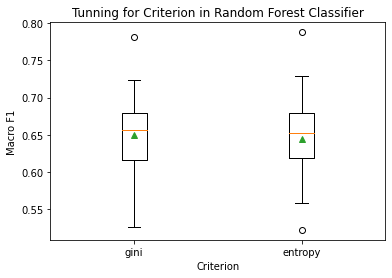

In [435]:
# plot model performance for comparison
pyplot.boxplot(resultsOfModel, labels=namesOfModel, showmeans=True)
pyplot.xlabel("Criterion")
pyplot.ylabel("Macro F1")
pyplot.title("Tunning for Criterion in Random Forest Classifier")
pyplot.show()

#### 2. n_estimators

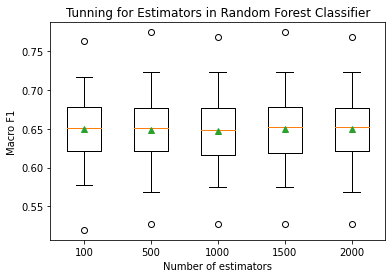

In [436]:
# Getting a dataset
def getting_dataset():
    X = dataTN.iloc[:,:-1]
    y = dataTN['Phenotype']
    return X, y
 
def getting_models():
    model = dict()
    # Tree list 
    trees = [100, 500, 1000,1500,2000]
    # Runing a loop 
    for n in trees:
        model[str(n)] = RandomForestClassifier(n_estimators=n)
    return model
 
# Function for running teh dataset     
def evaluating_models(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores
 

# Calling datasets     
X, y = getting_datasets()

# Initialising models 
modelsTorun = getting_models()

# Saving results form each model 
resultsOfModel, namesOfModel = list(), list()

# Running loop
for names, model in modelsTorun.items():
    # Scoring for each model 
    scores = evaluating_models(model, X, y)
    resultsOfModel.append(scores)
    namesOfModel.append(names)

# Plot for model perfirmance
pyplot.boxplot(resultsOfModel, labels=namesOfModel, showmeans=True)
pyplot.xlabel("Number of estimators")
pyplot.ylabel("Macro F1")
pyplot.title("Tunning for Estimators in Random Forest Classifier")
pyplot.show() 

#### 3. Depth of the tree

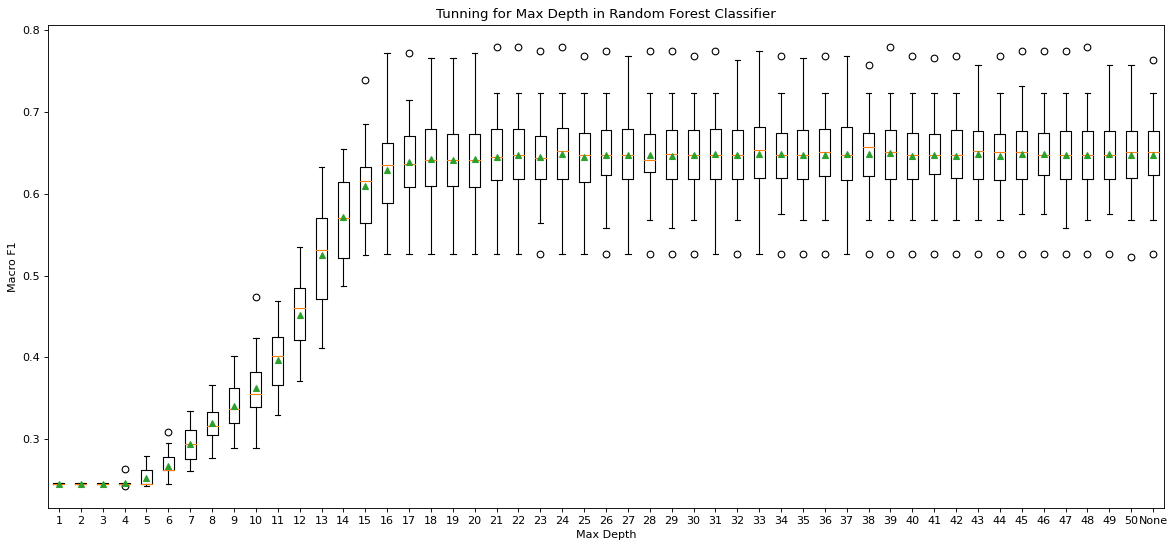

In [201]:
def getting_dataset():
    X = dataTN.iloc[:,:-1]
    y = dataTN['Phenotype']
    return X, y
 
# get a list of models to evaluate
def getting_models():
    model = dict()
    depthsOfModel = [depth for depth in range(1, 51)] + [None]
    
    # Running a loop 
    for depth in depthsOfModel:
        model[str(depth)] = RandomForestClassifier(max_depth=depth,n_estimators=1000)
    return model
 

def evaluating_models(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores


# Calling datasets     
X, y = getting_datasets()

# Initialising models 
modelsTorun = getting_models()

# Saving results form each model 
resultsOfModel, namesOfModel = list(), list()

# Running loop
for names, model in modelsTorun.items():
    # Scoring for each model 
    scores = evaluating_models(model, X, y)
    resultsOfModel.append(scores)
    namesOfModel.append(names)
    
    
from matplotlib.pyplot import figure

figure(figsize=(18, 8), dpi=80)
pyplot.boxplot(resultsOfModel, labels=namesOfModel, showmeans=True)
pyplot.xlabel("Max Depth")
pyplot.ylabel("Macro F1")
pyplot.title("Tunning for Max Depth in Random Forest Classifier")
pyplot.show()

#### 4. Maximum features 

>auto/sqrt 0.642 (0.054)
>log2 0.448 (0.044)
>None 0.662 (0.047)


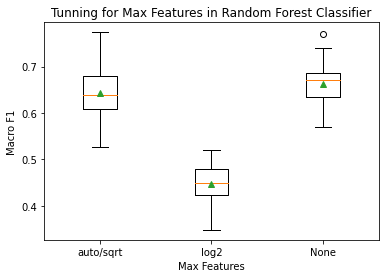

In [202]:
def getting_dataset():
    X = dataTN.iloc[:,:-1]
    y = dataTN['Phenotype']
    return X, y
 
def getting_models():
    models = dict()

    ls = ["auto"," “sqrt”, “log2",None]
    models["auto/sqrt"] = RandomForestClassifier(max_features="auto",max_depth=20,n_estimators=1000)
    models["log2"] = RandomForestClassifier(max_features="log2",max_depth=20,n_estimators=1000)
    models["None"] = RandomForestClassifier(max_features=None,max_depth=20,n_estimators=1000)
    
    return models
 
def evaluating_models(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores


# Calling datasets     
X, y = getting_datasets()

# Initialising models 
modelsTorun = getting_models()

# Saving results form each model 
resultsOfModel, namesOfModel = list(), list()

# Running loop
for names, model in modelsTorun.items():
    # Scoring for each model 
    scores = evaluating_models(model, X, y)
    resultsOfModel.append(scores)
    namesOfModel.append(names)
    
pyplot.boxplot(resultsOfModel, labels=namesOfModel, showmeans=True)
pyplot.xlabel("Max Features")
pyplot.ylabel("Macro F1")
pyplot.title("Tunning for Max Features in Random Forest Classifier")
pyplot.show()

#### 5. Minimum samples leaf

In [ ]:

def getting_dataset():
    X = dataTN.iloc[:,:-1]
    y = dataTN['Phenotype']
    return X, y
 
 
# get a list of models to evaluate
def getting_models():
    model = dict()
    for i in range(1,30,2):
        model[str(i)] = RandomForestClassifier(min_samples_leaf =i,max_features="auto",max_depth=20,n_estimators=1000)
    return model
 
# evaluate a given model using cross-validation
def evaluating_models(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores
 

# Calling datasets     
X, y = getting_datasets()

# Initialising models 
modelsTorun = getting_models()

# Saving results form each model 
resultsOfModel, namesOfModel = list(), list()

# Running loop
for names, model in modelsTorun.items():
    # Scoring for each model 
    scores = evaluating_models(model, X, y)
    resultsOfModel.append(scores)
    namesOfModel.append(names)
    # print('>',names and mean(scores) along with standard deviation of scores


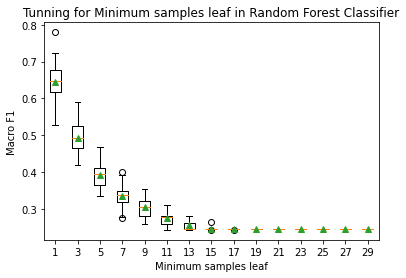

In [439]:
pyplot.boxplot(resultsOfModel, labels=namesOfModel, showmeans=True)
pyplot.xlabel("Minimum samples leaf")
pyplot.ylabel("Macro F1")
pyplot.title("Tunning for Minimum samples leaf in Random Forest Classifier")
pyplot.show()

In [425]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
import numpy as np
# GSxNAG
# GSxPTC
# NAGxPTC

ENXn = np.array(GSxNAG[[top_varaibles[x] for x in selected_features]])

ENtrain_features, ENtest_features, ENtrain_labels, ENtest_labels = train_test_split(
    ENXn, 
    np.array(GSxNAG['Phenotype']), test_size = 0.25, random_state = 42)
from sklearn.ensemble import RandomForestClassifier
ENrf = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42)
ENrf.fit(ENtrain_features,ENtrain_labels)
ENprediction=ENrf.predict(ENtest_features)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENtest_labels, ENprediction))
print("F1 macro:",metrics.f1_score(ENtest_labels, ENprediction,average="macro"))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ENtest_labels, ENprediction))
print(classification_report(ENtest_labels, ENprediction))

Accuracy: 0.9140625
F1 macro: 0.7561904761904762


In [426]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ENtest_labels, ENprediction))
print(classification_report(ENtest_labels, ENprediction))

[[  7  11]
 [  0 110]]


## Initial Model and Variable selection

In [440]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
import numpy as np

ENXn = np.array(dataTN.iloc[:,:-1])


ENtrain_features, ENtest_features, ENtrain_labels, ENtest_labels = train_test_split(
    ENXn, np.array(dataTN['Phenotype']), test_size = 0.25, random_state = 42)

from sklearn.ensemble import RandomForestClassifier
ENrf = RandomForestClassifier(criterion='gini',max_depth=20,n_estimators=1000,random_state=42,n_jobs=-1)
                          

ENrf.fit(ENtrain_features,ENtrain_labels)

ENprediction=ENrf.predict(ENtest_features)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENtest_labels, ENprediction))
print("f1_score macro:",metrics.f1_score(ENtest_labels, ENprediction,average="macro"))


Accuracy: 0.7988826815642458
f1_score macro: 0.7095827648356833


In [441]:
import pandas as pd
feature_imp = pd.Series(ENrf.feature_importances_,index=dataTN.iloc[:,:-1].columns).sort_values(ascending=False)

In [442]:
feature_impDF = pd.DataFrame({'Features':feature_imp.index, 'Importance':feature_imp.values})

In [451]:
feature_impDF

Features  Importance
0          221331.T/C    0.002591
1          962858.G/A    0.001864
2       1115013.G/A,T    0.001660
3      712033.A/C,G,T    0.001596
4          908373.T/C    0.001425
...               ...         ...
29586      828682.C/A    0.000000
29587      828668.A/G    0.000000
29588      828666.T/C    0.000000
29589      828662.G/A    0.000000
29590     1484944.A/G    0.000000

[29591 rows x 2 columns]

#### Distribution of Variable Importance Measure values for all features

/home/vbha0006/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'VIM'),
 Text(0, 0.5, 'Number of Variables'),
 Text(0.5, 1.0, 'Distribution of Variables ')]

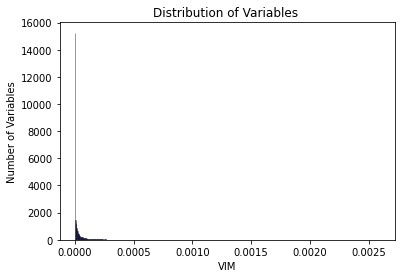

In [452]:
import matplotlib.pyplot as plt
import seaborn as sns


# seaborn histogram

sns.distplot(list(feature_imp.values), hist=True, kde=False, 
             bins=800, color = 'blue',
             hist_kws={'edgecolor':'black'}).set(xlabel="VIM",ylabel='Number of Variables',title='Distribution of Variables ')

/home/vbha0006/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'VIM'),
 Text(0, 0.5, 'Number of Variables'),
 Text(0.5, 1.0, 'Distribution of Variables ')]

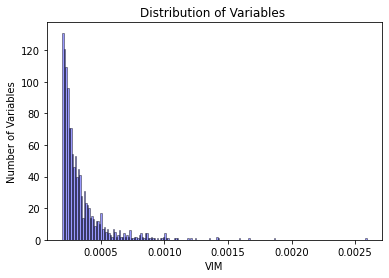

In [453]:
import seaborn as sns

top_varaibles_values = list(feature_impDF['Importance'][feature_impDF["Importance"]>0.0002])
# seaborn histogram

sns.distplot(top_varaibles_values, hist=True, kde=False, 
             bins=200, color = 'blue',
             hist_kws={'edgecolor':'black'}).set(xlabel="VIM",ylabel='Number of Variables',title='Distribution of Variables ')

#### Understanding Model Accuracy with respect to VIM or number of features

In [454]:
ENrfRE = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42)
info_df=pd.DataFrame()
for i in range(250,1,-1):
    vim_temp = 0.00001*i
    top_varaiblesTesting = list(feature_impDF['Features'][feature_impDF["Importance"]>=vim_temp])
    
    ENXnRe = np.array(dataTN[top_varaiblesTesting])


# Split the data into training and testing sets
    ENRtrain_features, ENRtest_features, ENRtrain_labels, ENRtest_labels = train_test_split(
        ENXnRe, np.array(dataTN['Phenotype']), test_size = 0.25, random_state = 42)

    ENrfRE.fit(ENRtrain_features,ENRtrain_labels)

    ENRprediction=ENrfRE.predict(ENRtest_features)
    ENRprediction1=ENrfRE.predict(ENRtrain_features)

    mn= pd.DataFrame(columns = ['vim above or equal','accuracy'])
    mn.loc[0,'vim above or equal']=vim_temp
    mn.loc[0,'Test Accuracy']= metrics.accuracy_score(ENRtest_labels, ENRprediction)
    mn.loc[0,'Train Accuracy']= metrics.accuracy_score(ENRtrain_labels, ENRprediction1)

    mn.loc[0,'Number of Variables selected'] = len(top_varaiblesTesting)
    print(mn)
    info_df = pd.concat([info_df,mn],axis=0)

for i in range(19,10,-1):
    vim_temp = 0.000001*i
    top_varaiblesTesting = list(feature_impDF['Features'][feature_impDF["Importance"]>=vim_temp])
    
    ENXnRe = np.array(dataTN[top_varaiblesTesting])


# Split the data into training and testing sets
    ENRtrain_features, ENRtest_features, ENRtrain_labels, ENRtest_labels = train_test_split(
        ENXnRe, np.array(dataTN['Phenotype']), test_size = 0.25, random_state = 42)
    ENrfRE.fit(ENRtrain_features,ENRtrain_labels)

    ENRprediction=ENrfRE.predict(ENRtest_features)
    ENRprediction1=ENrfRE.predict(ENRtrain_features)

    mn= pd.DataFrame(columns = ['vim above or equal','accuracy'])
    mn.loc[0,'vim above or equal']=vim_temp
    mn.loc[0,'Test Accuracy']= metrics.accuracy_score(ENRtest_labels, ENRprediction)
    mn.loc[0,'Train Accuracy']= metrics.accuracy_score(ENRtrain_labels, ENRprediction1)

    mn.loc[0,'Number of Variables selected'] = len(top_varaiblesTesting)
    
    print(mn)
    info_df = pd.concat([info_df,mn],axis=0)
    

  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0             0.0025      NaN       0.581006        0.590654   

   Number of Variables selected  
0                           1.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0            0.00249      NaN       0.581006        0.590654   

   Number of Variables selected  
0                           1.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0            0.00248      NaN       0.581006        0.590654   

   Number of Variables selected  
0                           1.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0            0.00247      NaN       0.581006        0.590654   

   Number of Variables selected  
0                           1.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0            0.00246      NaN       0.581006        0.590654   

   Number of Variables selected  
0                           1.0  
  vim above or 

In [455]:
info_df = info_df.reset_index()

info_dfT = info_df
info_dfT['VIM Above or Equal']=info_dfT['vim above or equal']



[Text(0.5, 1.0, 'Accuracy of the Model with VIM above or equal to a specif value')]

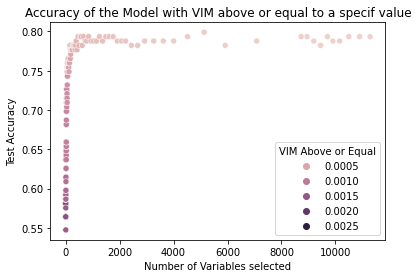

In [462]:
import seaborn as sns
sns.scatterplot(data=info_df, y="Test Accuracy", x="Number of Variables selected",
                hue='VIM Above or Equal').set(title='Accuracy of the Model with VIM above or equal to a specif value')

# Plot 1

[Text(0.5, 1.0, 'Accuracy of the Model with varying number of Variables.'),
 Text(0, 0.5, 'Acurracy')]

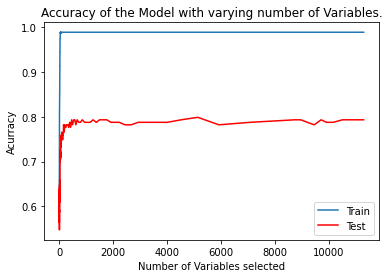

In [459]:
fig, ax = plt.subplots()
sns.lineplot(data=info_dfT, y="Train Accuracy", x="Number of Variables selected", label='Train',
               ).set(title='Accuracy of the Model with VIM above or equal to a specific value')
sns.lineplot(data=info_dfT, y="Test Accuracy", x="Number of Variables selected",label='Test', 
             color='r' ).set(title='Accuracy of the Model with varying number of Variables.',ylabel='Acurracy')

# Plot2 

[Text(0.5, 1.0, 'Accuracy of the Model with VIM above or equal to a specific value.'),
 Text(0, 0.5, 'Acurracy')]

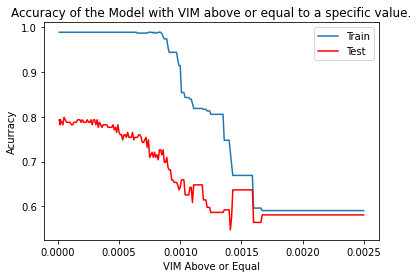

In [460]:
fig, ax = plt.subplots()
sns.lineplot(data=info_dfT, y="Train Accuracy", x="VIM Above or Equal", label='Train',
               ).set(title='Accuracy of the Model with VIM above or equal to a specific value')
sns.lineplot(data=info_dfT, y="Test Accuracy", x="VIM Above or Equal",label='Test', 
             color='r' ).set(title='Accuracy of the Model with VIM above or equal to a specific value.',ylabel='Acurracy')

Selection of variables above VIM *0.0002*

In [464]:
top_varaibles = list(feature_impDF['Features'][feature_impDF["Importance"]>0.0002])
len(top_varaibles)

1254

Model running after soft cutt off 

In [471]:
from sklearn.model_selection import train_test_split
import numpy as np

ENXnRe = np.array(dataTN[top_varaibles])


ENRtrain_features, ENRtest_features, ENRtrain_labels, ENRtest_labels = train_test_split(
    ENXnRe, np.array(dataTN['Phenotype']), test_size = 0.25, random_state = 42)

from sklearn.ensemble import RandomForestClassifier
ENrfRE = RandomForestClassifier(max_features="auto",max_depth=20,n_estimators=1000,random_state = 42)
                            

ENrfRE.fit(ENRtrain_features,ENRtrain_labels)

ENRprediction=ENrfRE.predict(ENRtest_features)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENRtest_labels, ENRprediction))

Accuracy: 0.7932960893854749


### Correlation Among Selected Features


In [42]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


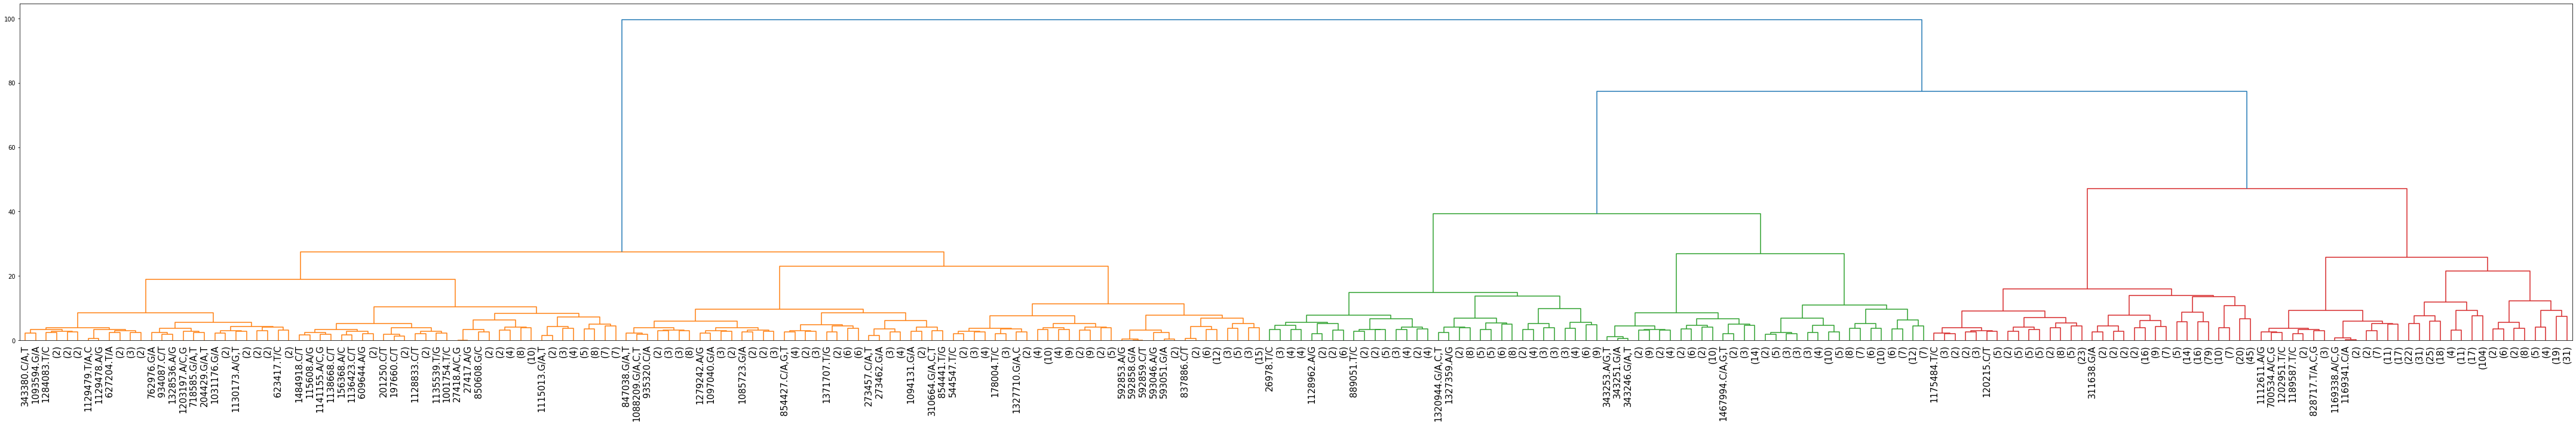

In [477]:
fig, (ax1) = plt.subplots(figsize=(60,10))
corr_Spearman_linkage = hierarchy.ward(spearmanr(ENXnRe).correlation)
dendro = hierarchy.dendrogram(
    corr_Spearman_linkage, labels=top_varaibles, ax=ax1, leaf_rotation=90, leaf_font_size=15, truncate_mode = 'level', p=7
)

dendro_idx = np.arange(0, len(dendro['ivl']))
fig.tight_layout()
fig.tight_layout()
plt.show()

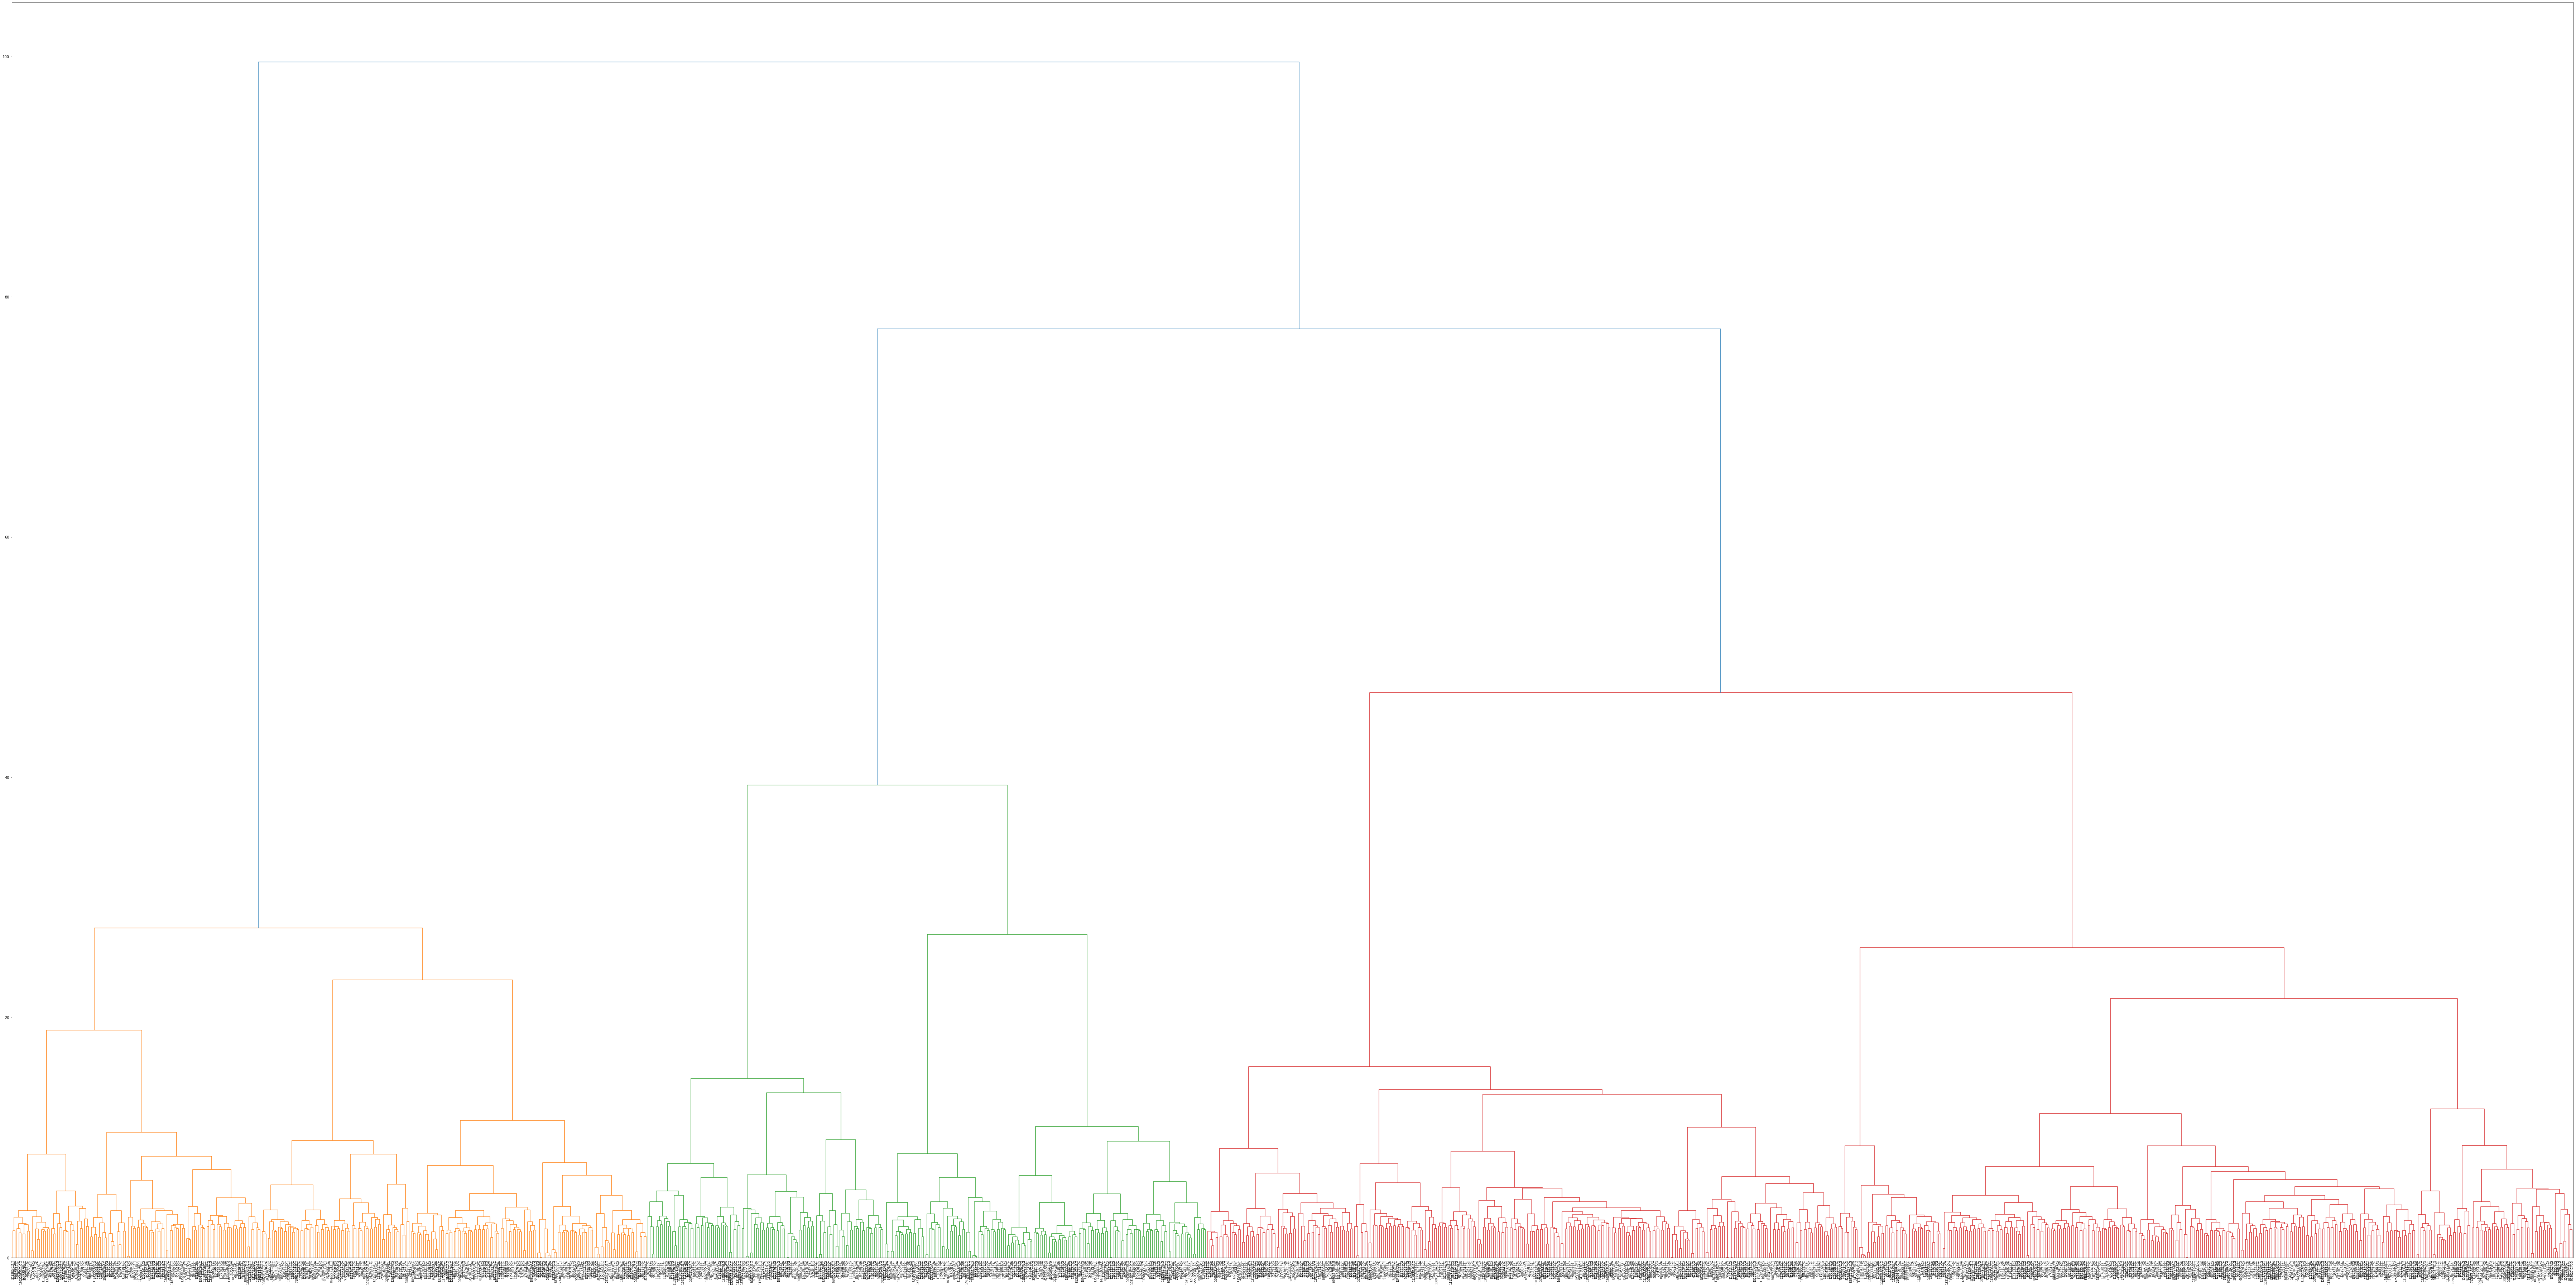

In [478]:
fig, (ax1) = plt.subplots(figsize=(100,50))

corr_Spearman_linkage = hierarchy.ward(spearmanr(ENXnRe).correlation)

dendrogram_plot = hierarchy.dendrogram(
    corr_Spearman_linkage, labels=top_varaibles, ax=ax1, leaf_rotation=90, leaf_font_size=8)

dendro_idx = np.arange(0, len(dendrogram_plot['ivl']))
# plotting
fig.tight_layout()
fig.tight_layout()
plt.show()

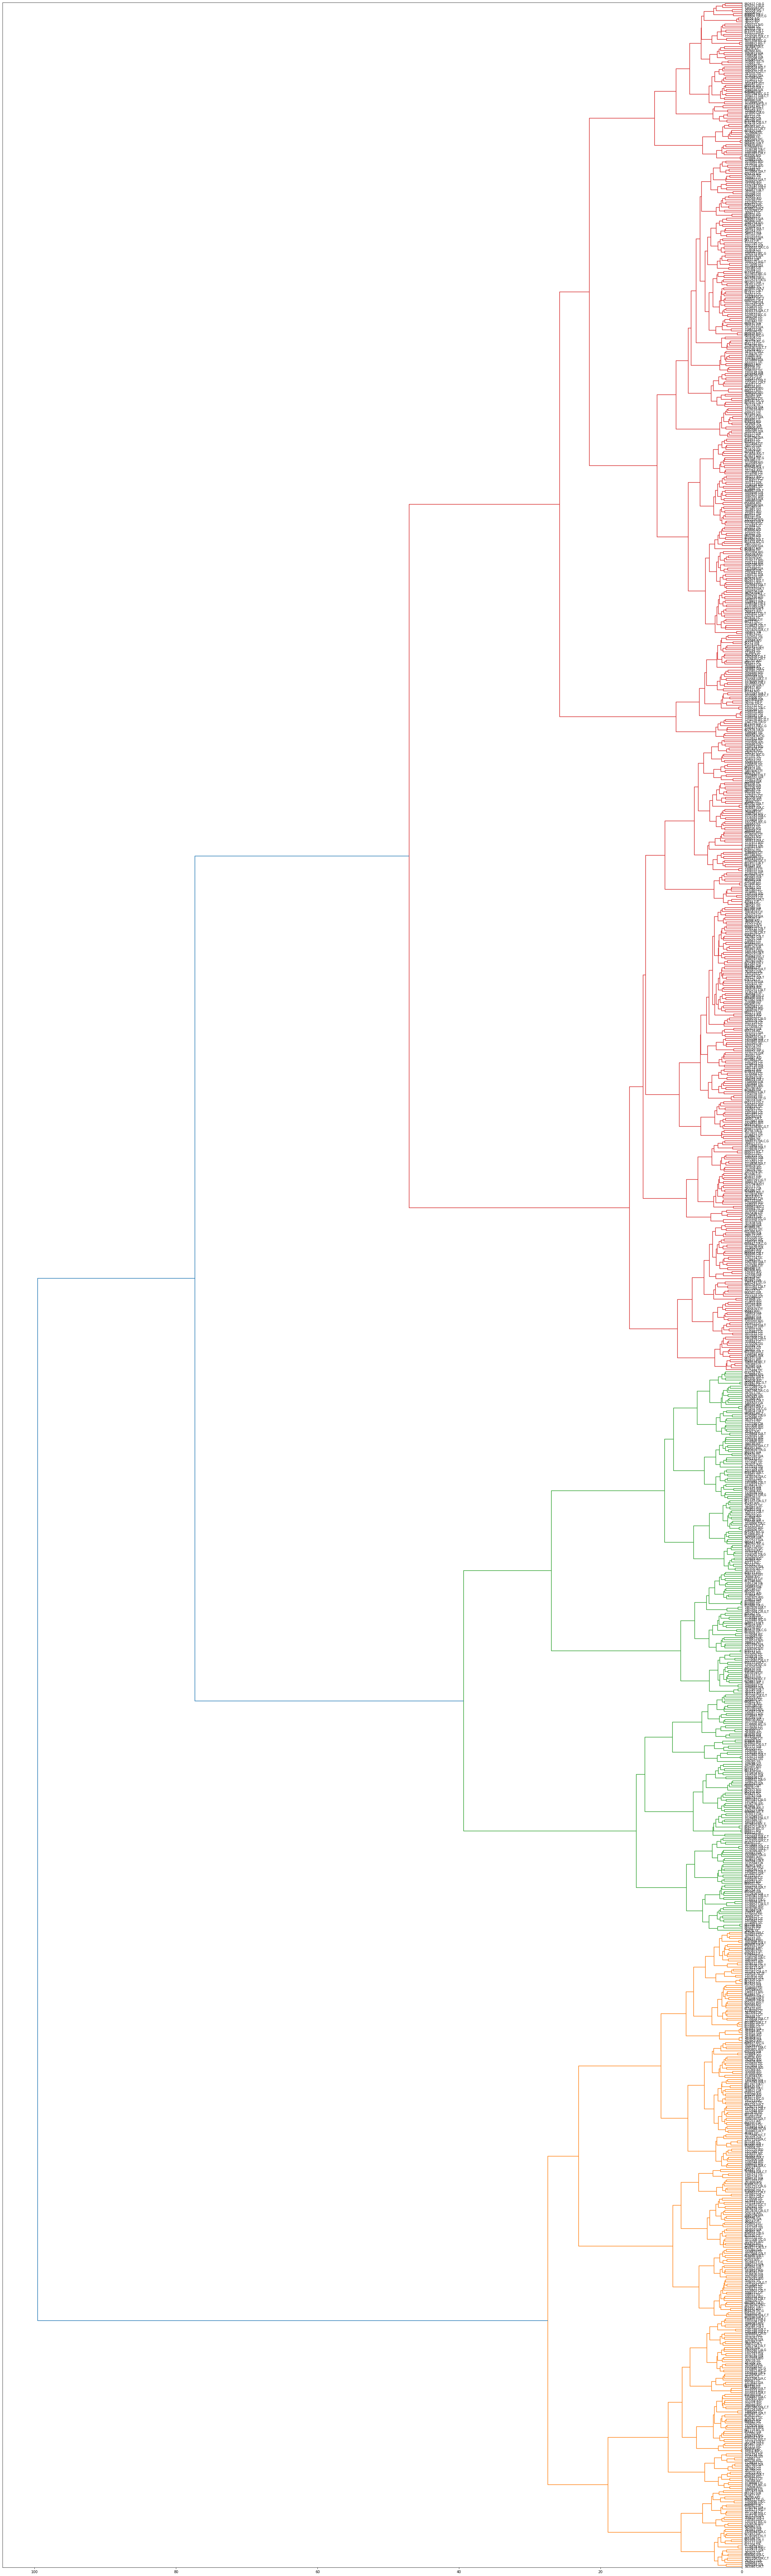

In [482]:
fig, (ax1) = plt.subplots(figsize=(30,100))

corr_Spearman_linkage = hierarchy.ward(spearmanr(ENXnRe).correlation)

dendrogram_plot = hierarchy.dendrogram(
    corr_Spearman_linkage, labels=top_varaibles, ax=ax1, leaf_font_size=8, orientation="left")

dendro_idx = np.arange(0, len(dendrogram_plot['ivl']))
# plotting
fig.tight_layout()
fig.tight_layout()
plt.show()

#### Correlation Among Selected Features and Feature Clustering

In [483]:
clt_id2fea_ids = defaultdict(list)
# selrting distance as "4"
clt_ids = hierarchy.fcluster(corr_Spearman_linkage, 4, criterion='distance')

for index, clt_id in enumerate(clt_ids):
    clt_id2fea_ids[clt_id].append(index)
    
selected_features = [i[0] for i in clt_id2fea_ids.values()]


In [484]:
len(selected_features)

142

In [205]:

from sklearn.model_selection import train_test_split
import numpy as np

ENXnRet = np.array(dataTN[[top_varaibles[x] for x in selected_features]])


# Split the data into training and testing sets
ENRtrain_featuresT, ENRtest_featuresT, ENRtrain_labelsT, ENRtest_labelsT = train_test_split(ENXnRet, 
                                                                                            np.array(dataTN['Phenotype']), 
                                                                                            test_size = 0.25, 
                                                                                            random_state = 42)

from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
ENrfRET = RandomForestClassifier(max_features="auto",max_depth=20,n_estimators=1000,random_state = 42)
                             #, min_samples_split=5,max_terminal_nodes=10, min_samples_leaf=200,random_state = 42)
# Train the model on training data

ENrfRET.fit(ENRtrain_featuresT,ENRtrain_labelsT)

ENRpredictionT=ENrfRET.predict(ENRtest_featuresT)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENRtest_labelsT, ENRpredictionT))
print("Accuracy:",metrics.f1_score(ENRtest_labelsT, ENRpredictionT,average="macro"))

Accuracy: 0.8044692737430168
Accuracy: 0.7326959752566724


In [471]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    visualizer = ROCAUC(model)
                                        
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
  

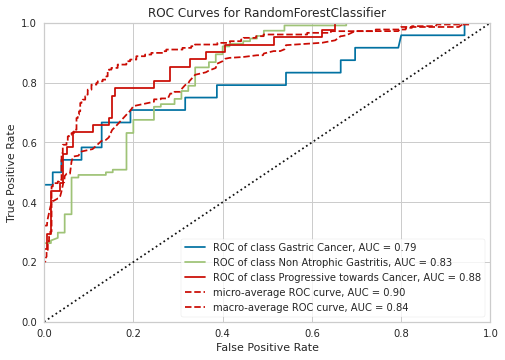

In [472]:
plot_ROC_curve(ENrfRET,ENRtrain_featuresT,ENRtrain_labelsT,ENRtest_featuresT,ENRtest_labelsT )

For class imbalance

In [411]:
from sklearn.model_selection import train_test_split
import numpy as np


ENXn = np.array(GSxPTC[[top_varaibles[x] for x in selected_features]])


ENtrain_features, ENtest_features, ENtrain_labels, ENtest_labels = train_test_split(
    ENXn, np.array(GSxPTC['Phenotype']), test_size = 0.25, random_state = 42)

from sklearn.ensemble import RandomForestClassifier
ENrf = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42, class_weight='balanced')
                           
ENrf.fit(ENtrain_features,ENtrain_labels)

ENprediction=ENrf.predict(ENtest_features)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ENtest_labels, ENprediction))
print("F1 macro:",metrics.f1_score(ENtest_labels, ENprediction,average="macro"))

Accuracy: 0.7866666666666666
F1 macro: 0.7272727272727273


In [408]:
from sklearn.model_selection import train_test_split
import numpy as np
# GSxNAG
# GSxPTC
# NAGxPTC

ENXn = np.array(NAGxPTC[[top_varaibles[x] for x in selected_features]])


ENtrain_features, ENtest_features, ENtrain_labels, ENtest_labels = train_test_split(
    ENXn, np.array(NAGxPTC['Phenotype']), test_size = 0.20, random_state = 42)

from sklearn.ensemble import RandomForestClassifier
ENrf = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42)
                           

ENrf.fit(ENtrain_features,ENtrain_labels)

ENprediction=ENrf.predict(ENtest_features)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENtest_labels, ENprediction))
print("F1 macro:",metrics.f1_score(ENtest_labels, ENprediction,average="macro"))

Accuracy: 0.8870967741935484
F1 macro: 0.8630050505050505


In [95]:
class_weightm = dict({'Gastric Cancer':4, "Non Atrophic Gastritis":1
                      , "Progressive towards Cancer":2})

from sklearn.model_selection import train_test_split
import numpy as np

ENXnRet = np.array(dataTN[[top_varaibles[x] for x in selected_features]])


# Split the data into training and testing sets
ENRtrain_featuresT, ENRtest_featuresT, ENRtrain_labelsT, ENRtest_labelsT = train_test_split(ENXnRet, 
                                                                                            np.array(dataTN['Phenotype']),
                                                                                            test_size = 0.25, 
                                                                                            random_state = 42)

from sklearn.ensemble import RandomForestClassifier
ENrfRET = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42,class_weight=class_weightm)
                            

ENrfRET.fit(ENRtrain_featuresT,ENRtrain_labelsT)

ENRpredictionT=ENrfRET.predict(ENRtest_featuresT)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ENRtest_labelsT, ENRpredictionT))


print(classification_report(ENRtest_labelsT, ENRpredictionT))

Accuracy: 0.770949720670391
                            precision    recall  f1-score   support

            Gastric Cancer       1.00      0.46      0.63        24
    Non Atrophic Gastritis       0.78      0.90      0.84       114
Progressive towards Cancer       0.67      0.59      0.62        41

                  accuracy                           0.77       179
                 macro avg       0.82      0.65      0.70       179
              weighted avg       0.78      0.77      0.76       179



##### VIM

In [281]:
feature_imp1 = pd.Series(ENrfRET.feature_importances_,
                         index=dataTN[[top_varaibles[x] for x in 
                                       selected_features]].iloc[:,:].columns).sort_values(ascending=False)

feature_impDF1 = pd.DataFrame({'Features':feature_imp1.index, 'Importance':feature_imp1.values})


feature_impDF1[:10]

###### Boruta 

In [235]:

feat_mine = BorutaPy(ENrfRET, n_estimators ='auto', verbose=2, random_state=1,max_iter = 50,perc=80,two_step =False)


feat_mine.fit(ENRtrain_featuresT,ENRtrain_labelsT)


Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	9 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	10 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	11 / 50
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	12 / 50
Confirmed: 	46
Tentative: 	88
Rejected: 	8
Iteration: 	13 / 50
Confirmed: 	46
Tentative: 	88
Rejected: 	8
Iteration: 	14 / 50
Confirmed: 	46
Tentative: 	88
Rejected: 	8
Iteration: 	15 / 50
Confirmed: 	46
Tentative: 	88
Rejected: 	8
Iteration: 	16 / 50
Confirmed: 	54
Tentative: 	76
Rejected: 	12


In [378]:
from boruta import BorutaPy
feature_ranks101 = list(zip(selected_features, 
                         feat_mine.ranking_, 
                         feat_mine.support_))

for feat in feature_ranks101:
    print(feat[0], feat[1], feat[2])

Feature: 0                         Rank: 1,  Keep: True
Feature: 1                         Rank: 1,  Keep: True
Feature: 2                         Rank: 1,  Keep: True
Feature: 3                         Rank: 1,  Keep: True
Feature: 4                         Rank: 1,  Keep: True
Feature: 6                         Rank: 14,  Keep: False
Feature: 7                         Rank: 1,  Keep: True
Feature: 8                         Rank: 1,  Keep: True
Feature: 9                         Rank: 1,  Keep: True
Feature: 10                        Rank: 1,  Keep: True
Feature: 11                        Rank: 1,  Keep: True
Feature: 13                        Rank: 1,  Keep: True
Feature: 14                        Rank: 1,  Keep: True
Feature: 16                        Rank: 1,  Keep: True
Feature: 17                        Rank: 1,  Keep: True
Feature: 18                        Rank: 1,  Keep: True
Feature: 19                        Rank: 1,  Keep: True
Feature: 20                        Rank: 1,  K

#### Data Wrangling for final list of features with meta data

In [63]:
final_variable_list = [top_varaibles[x] for x in selected_features]

In [ ]:
len(selected_features)

In [418]:
final_variable_list[:5]

['221331.T/C', '962858.G/A', '1115013.G/A,T', '712033.A/C,G,T', '908373.T/C']

In [696]:
read_variant_dict_gtf = pd.read_csv(r'../data/new_gtf.txt' ,error_bad_lines=False, sep="\t",header=None)

read_variant_dict_gtf = read_variant_dict_gtf[read_variant_dict_gtf[2]=="gene"]

for index, row in read_variant_dict_gtf.iterrows():
    
    read_variant_dict_gtf.loc[index, "gene_name" ]=read_variant_dict_gtf.loc[index,8].split()[5][1:-2]

read_variant_dict_gtf = read_variant_dict_gtf[read_variant_dict_gtf["gene_name"]!="protein_coding"]

In [697]:
read_variant_dict_gtf

0        1     2        3        4  5  6  7  \
0     CP001217.1  Genbank  gene       13      429  .  -  .   
8     CP001217.1  Genbank  gene      911     1741  .  -  .   
16    CP001217.1  Genbank  gene     2515     3198  .  +  .   
20    CP001217.1  Genbank  gene     3199     4029  .  +  .   
24    CP001217.1  Genbank  gene     4043     4118  .  -  .   
...          ...      ...   ...      ...      ... .. .. ..   
6308  CP001217.1  Genbank  gene  1662090  1662362  .  +  .   
6336  CP001217.1  Genbank  gene  1667383  1668171  .  +  .   
6340  CP001217.1  Genbank  gene  1668173  1669096  .  +  .   
6344  CP001217.1  Genbank  gene  1669161  1670183  .  +  .   
6348  CP001217.1  Genbank  gene  1670362  1671150  .  +  .   

                                                      8 gene_name  
0     gene_id "HPP12_0001"; gbkey "Gene"; gene "nusB...      nusB  
8     gene_id "HPP12_0003"; gbkey "Gene"; gene "kdsA...      kdsA  
16    gene_id "HPP12_0005"; gbkey "Gene"; gene "pyrF...      pyrF  
20    gene_id "HPP12_0006"; gbkey "Gene"; gene "panC...      panC  
24    gene_id "HPP12_t01"; gbkey "Gene"; gene_biotyp...      tRNA  
...                                                 ...       ...  
6308  gene_id "HPP12_1566"; gbkey "Gene"; gene "flhB...    flhB-2  
6336  gene_id "HPP12_1573"; gbkey "Gene"; gene "pdxJ...      pdxJ  
6340  gene_id "HPP12_1574"; gbkey "Gene"; gene "pdxA...      pdxA  
6344  gene_id "HPP12_1575"; gbkey "Gene"; gene "ydiE...      ydiE  
6348  gene_id "HPP12_1576"; gbkey "Gene"; gene "flgG...    flgG-2  

[785 rows x 10 columns]

In [59]:
temp_gtf = pd.read_csv(r'../data/new_gtf.txt' ,error_bad_lines=False, sep="\t",header=None)
#temp_gtf = temp_gtf[temp_gtf[2]=="CDS"]


In [751]:
temp_gtf[8][1]

'gene_id "HPP12_0001"; transcript_id "unknown_transcript_1"; gbkey "CDS"; gene "nusB"; locus_tag "HPP12_0001"; note "transcriptional antitermination factor"; product "N utilization substance protein B"; protein_id "ACJ07161.1"; transl_table "11"; '

In [60]:
for i in temp_gtf[8][1].strip(" ").split(";")[:-1]:
    print(i.strip().split(" ",1)[1])
    
for index, row in temp_gtf.iterrows():
    for i in temp_gtf[8][index].strip(" ").split(";")[:-1]:

        temp_gtf.loc[index, i.strip().split(" ",1)[0]]=i.strip().split(" ",1)[1]


"HPP12_0001"
"unknown_transcript_1"
"CDS"
"nusB"
"HPP12_0001"
"transcriptional antitermination factor"
"N utilization substance protein B"
"ACJ07161.1"
"11"


In [709]:
temp_gtf[8][0]

'gene_id "HPP12_0001"; gbkey "Gene"; gene "nusB"; gene_biotype "protein_coding"; locus_tag "HPP12_0001"; '

In [614]:
read_variant_dict_gff = pd.read_csv(r'../data/new_gff.txt' ,error_bad_lines=False, sep="\t",header=None)
read_variant_dict_gff = read_variant_dict_gff[read_variant_dict_gff[2]=="gene"]

for index, row in read_variant_dict_gff.iterrows():
    
    read_variant_dict_gff.loc[index, "gene_name" ]=read_variant_dict_gff.loc[index,8].split(";")[1][5:]
    
    
read_variant_dict_gff = read_variant_dict_gff[read_variant_dict_gff["gene_name"]

read_variant_dict_gff = pd.read_csv(r'../data/new_gff.txt' ,error_bad_lines=False, sep="\t",header=None)

read_variant_dict_gff[8][1].split(";")[1][5:]

In [64]:
final_variable_df = pd.DataFrame(final_variable_list)

In [65]:
for index, row in final_variable_df.iterrows():
    
    final_variable_df.loc[index, 1 ]=int(final_variable_df.loc[index,0].split(".")[0])
    final_variable_df.loc[index, 2 ]=final_variable_df.loc[index,0].split(".")[1]
    

In [66]:
final_variable_df

0          1        2
0        221331.T/C   221331.0      T/C
1        962858.G/A   962858.0      G/A
2     1115013.G/A,T  1115013.0    G/A,T
3    712033.A/C,G,T   712033.0  A/C,G,T
4        908373.T/C   908373.0      T/C
..              ...        ...      ...
137     1027216.C/T  1027216.0      C/T
138     1293845.T/C  1293845.0      T/C
139     1341574.C/T  1341574.0      C/T
140      676016.G/A   676016.0      G/A
141    314047.G/A,C   314047.0    G/A,C

[142 rows x 3 columns]

In [347]:
final_variable_df[:10]

0          1        2
0      221331.T/C   221331.0      T/C
1      962858.G/A   962858.0      G/A
2   1115013.G/A,T  1115013.0    G/A,T
3  712033.A/C,G,T   712033.0  A/C,G,T
4      908373.T/C   908373.0      T/C
5   1181754.C/A,T  1181754.0    C/A,T
6    310663.A/G,T   310663.0    A/G,T
7      878577.G/A   878577.0      G/A
8     1353700.T/C  1353700.0      T/C
9      962897.G/A   962897.0      G/A

In [349]:
feature_impDF1[:10]

Features  Importance
0   712033.A/C,G,T    0.018980
1       221331.T/C    0.018135
2     310663.A/G,T    0.015052
3   828717.T/A,C,G    0.014518
4       908373.T/C    0.013676
5    1115013.G/A,T    0.013079
6    1181754.C/A,T    0.012954
7       962858.G/A    0.012850
8  1131910.G/A,C,T    0.012523
9    1009179.C/A,T    0.012106

In [131]:
temp_gtf_final = pd.DataFrame()
#for i in list(final_variable_df[1]):
for index, row in final_variable_df.iterrows():

    temp_gtfi = temp_gtf[(temp_gtf[3]<= final_variable_df.loc[index, 1 ]) & (temp_gtf[4]>=final_variable_df.loc[index, 1 ])]
    temp_gtfi = temp_gtfi[(temp_gtfi[2]=="CDS")]
    temp_gtfi['Phenotype']=final_variable_df.loc[index, 0 ]
    temp_gtfi['CDS Start'] = temp_gtfi[3]
    temp_gtfi['CDS End'] = temp_gtfi[4]
    temp_gtfi['Gene ID'] = temp_gtfi['gene_id']
    temp_gtfi['Product'] = temp_gtfi['product']
    print(temp_gtfi)
    #print(len(temp_gtfi))
    temp_gtf_final = pd.concat([temp_gtf_final, temp_gtfi], axis=0)

              0        1    2       3       4  5  6  7  \
872  CP001217.1  Genbank  CDS  220874  221671  .  +  0   

                                                     8       gene_id  ...  \
872  gene_id "HPP12_0216"; transcript_id "unknown_t...  "HPP12_0216"  ...   

    exon_number probably exception interrupted missing   Phenotype CDS Start  \
872         NaN      NaN       NaN         NaN     NaN  221331.T/C    220874   

    CDS End       Gene ID                          Product  
872  221671  "HPP12_0216"  "cdp-diacylglycerol synthetase"  

[1 rows x 29 columns]
               0        1    2       3       4  5  6  7  \
3651  CP001217.1  Genbank  CDS  962720  964273  .  +  0   

                                                      8       gene_id  ...  \
3651  gene_id "HPP12_0910"; transcript_id "unknown_t...  "HPP12_0910"  ...   

     exon_number probably exception interrupted missing   Phenotype CDS Start  \
3651         NaN      NaN       NaN         NaN     NaN  962858.G

In [116]:
len(temp_gtf_final)

274

In [364]:
temp_gtf_final['gene']

872     "cdsA"
3651    "alpA"
4207       NaN
2678       NaN
3439    "waaE"
         ...  
3883       NaN
4883    "alaS"
5059       NaN
2542    "mutS"
1198    "dppA"
Name: gene, Length: 136, dtype: object

In [372]:
info_final_all3 = temp_gtf_final[['Phenotype','CDS Start','CDS End',"Gene ID","Product",'gene']]

In [ ]:
info_final_all3

In [373]:
info_final_all3 = info_final_all3.reset_index()
del info_final_all3['index']

In [374]:
info_final_all3

Phenotype  CDS Start  CDS End       Gene ID  \
0        221331.T/C     220874   221671  "HPP12_0216"   
1        962858.G/A     962720   964273  "HPP12_0910"   
2     1115013.G/A,T    1114613  1115281  "HPP12_1044"   
3    712033.A/C,G,T     709540   712278  "HPP12_0668"   
4        908373.T/C     908318   909700  "HPP12_0858"   
..              ...        ...      ...           ...   
131     1027216.C/T    1026881  1027957  "HPP12_0966"   
132     1293845.T/C    1293546  1296086  "HPP12_1207"   
133     1341574.C/T    1341103  1341837  "HPP12_1251"   
134      676016.G/A     673942   676191  "HPP12_0634"   
135    314047.G/A,C     312634   314283  "HPP12_0297"   

                                      Product    gene  
0             "cdp-diacylglycerol synthetase"  "cdsA"  
1          "outer membrane protein HopC/AlpA"  "alpA"  
2       "thiol:disulfide interchange protein"     NaN  
3            "protective surface antigen D15"     NaN  
4                      "ADP-heptose synthase"  "waaE"  
..                                        ...     ...  
131  "cobalt-zinc-cadmium resistance protein"     NaN  
132                  "alanyl-tRNA synthetase"  "alaS"  
133            "acid phosphatase lipoprotein"     NaN  
134             "DNA mismatch repair protein"  "mutS"  
135   "periplasmic dipeptide-binding protein"  "dppA"  

[136 rows x 6 columns]

In [368]:
info_final_all3.to_csv("print.csv")

In [ ]:
info_final_all3

#### SHAP

In [224]:
import shap

In [462]:
explainer = shap.TreeExplainer(ENrfRET)
shap_values = explainer.shap_values(dataTN[[top_varaibles[x] for x in selected_features]])

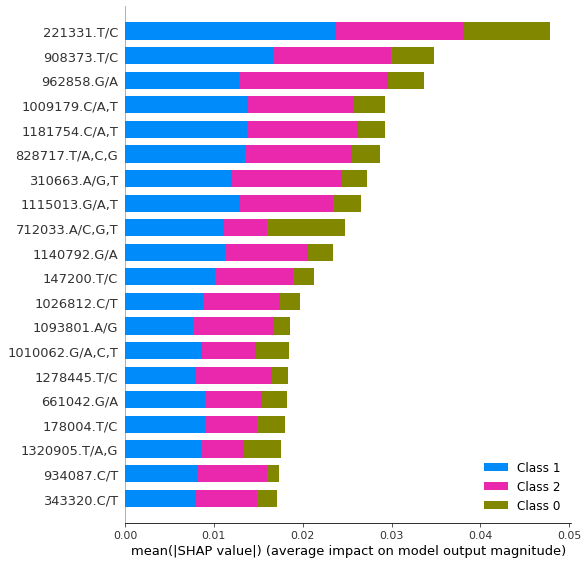

In [463]:
shap.summary_plot(shap_values, dataTN[[top_varaibles[x] for x in selected_features]])

In [448]:
df_mnlk = pd.DataFrame()
df_mnlk.loc[0,'Top 10 SHAP Features']='221331.T/C'
df_mnlk.loc[1,'Top 10 SHAP Features']='908373.T/C'
df_mnlk.loc[2,'Top 10 SHAP Features']='962858.G/A'
df_mnlk.loc[3,'Top 10 SHAP Features']='1009179.C/A,T'
df_mnlk.loc[4,'Top 10 SHAP Features']='1181754.C/A,T'
df_mnlk.loc[5,'Top 10 SHAP Features']='828717.T/A,C,G'
df_mnlk.loc[6,'Top 10 SHAP Features']='310663.A/G,T'
df_mnlk.loc[7,'Top 10 SHAP Features']='1115013.G/A,T'
df_mnlk.loc[8,'Top 10 SHAP Features']='712033.A/C,G,T'
df_mnlk.loc[9,'Top 10 SHAP Features']='1140792.G/A'

In [449]:
df_mnlk

Top 10 SHAP Features
0           221331.T/C
1           908373.T/C
2           962858.G/A
3        1009179.C/A,T
4        1181754.C/A,T
5       828717.T/A,C,G
6         310663.A/G,T
7        1115013.G/A,T
8       712033.A/C,G,T
9          1140792.G/A

In [351]:
feature_impDF1[:10]

Features  Importance
0   712033.A/C,G,T    0.018980
1       221331.T/C    0.018135
2     310663.A/G,T    0.015052
3   828717.T/A,C,G    0.014518
4       908373.T/C    0.013676
5    1115013.G/A,T    0.013079
6    1181754.C/A,T    0.012954
7       962858.G/A    0.012850
8  1131910.G/A,C,T    0.012523
9    1009179.C/A,T    0.012106

In [352]:
info_final_all3

Phenotype  CDS Start  CDS End       Gene ID  \
0        221331.T/C     220874   221671  "HPP12_0216"   
1        962858.G/A     962720   964273  "HPP12_0910"   
2     1115013.G/A,T    1114613  1115281  "HPP12_1044"   
3    712033.A/C,G,T     709540   712278  "HPP12_0668"   
4        908373.T/C     908318   909700  "HPP12_0858"   
..              ...        ...      ...           ...   
131     1027216.C/T    1026881  1027957  "HPP12_0966"   
132     1293845.T/C    1293546  1296086  "HPP12_1207"   
133     1341574.C/T    1341103  1341837  "HPP12_1251"   
134      676016.G/A     673942   676191  "HPP12_0634"   
135    314047.G/A,C     312634   314283  "HPP12_0297"   

                                      Product  
0             "cdp-diacylglycerol synthetase"  
1          "outer membrane protein HopC/AlpA"  
2       "thiol:disulfide interchange protein"  
3            "protective surface antigen D15"  
4                      "ADP-heptose synthase"  
..                                        ...  
131  "cobalt-zinc-cadmium resistance protein"  
132                  "alanyl-tRNA synthetase"  
133            "acid phosphatase lipoprotein"  
134             "DNA mismatch repair protein"  
135   "periplasmic dipeptide-binding protein"  

[136 rows x 5 columns]

In [375]:
new_df_vcf_phen101 = pd.DataFrame()
for i in range(len(feature_impDF1['Features'])):
    new =  info_final_all3[info_final_all3['Phenotype']==list(feature_impDF1['Features'])[i]]
    new_df_vcf_phen101 = pd.concat([new_df_vcf_phen101, new], axis=0)

In [376]:
new_df_vcf_phen101 = new_df_vcf_phen101.reset_index()
del new_df_vcf_phen101['index']

In [377]:
new_df_vcf_phen101.to_csv('print.csv')

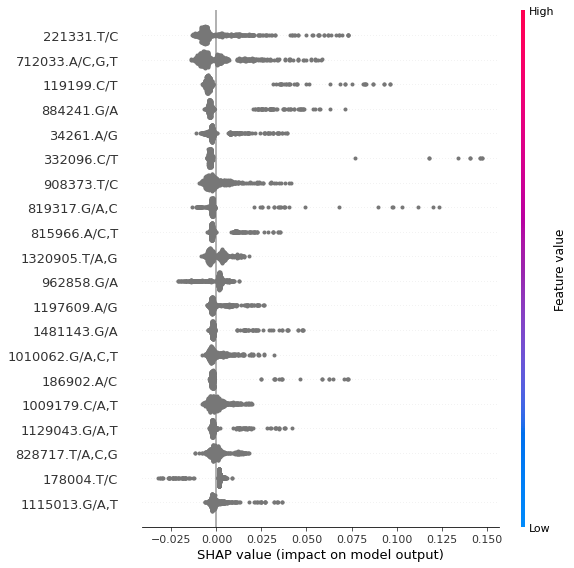

In [296]:
shap.summary_plot(shap_values[0], dataTN[[top_varaibles[x] for x in selected_features]])

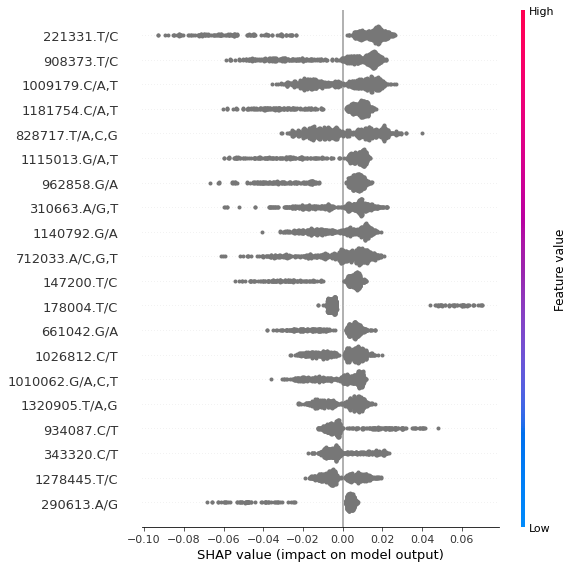

714

In [302]:
shap.summary_plot(shap_values[1], dataTN[[top_varaibles[x] for x in selected_features]])
len(shap_values[1])

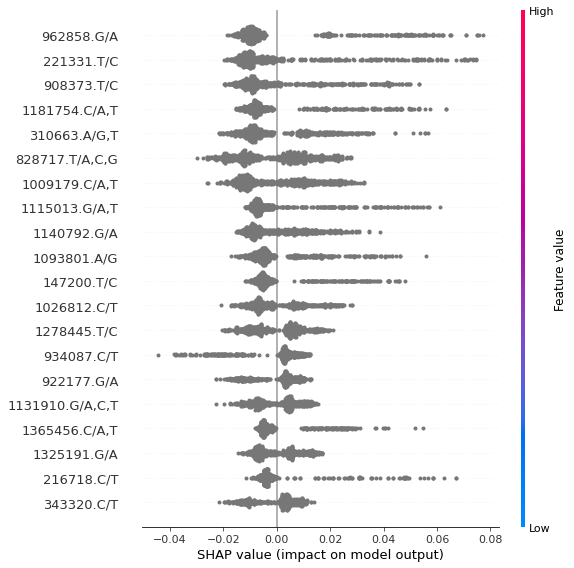

In [297]:
shap.summary_plot(shap_values[2], dataTN[[top_varaibles[x] for x in selected_features]])

In [468]:
vals= np.abs(shap_values[0]).mean(0)
feature_importance = pd.DataFrame(list(zip(dataTN[[top_varaibles[x] for x in selected_features]].columns,vals)),
                                  columns=['Top  10 SHAP Features for detecting Gastric Cancer','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance[:10]

Top  10 SHAP Features for detecting Gastric Cancer  feature_importance_vals
0                                          221331.T/C                 0.009661
3                                      712033.A/C,G,T                 0.008822
24                                         119199.C/T                 0.007481
88                                         884241.G/A                 0.006717
74                                          34261.A/G                 0.005263
11                                         332096.C/T                 0.005236
4                                          908373.T/C                 0.004803
32                                       819317.G/A,C                 0.004542
91                                       815966.A/C,T                 0.004207
58                                      1320905.T/A,G                 0.004160

In [464]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(dataTN[[top_varaibles[x] for x in selected_features]].columns,vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance[:20]

col_name  feature_importance_vals
0        221331.T/C                 0.023717
4        908373.T/C                 0.016667
19    1009179.C/A,T                 0.013820
5     1181754.C/A,T                 0.013696
15   828717.T/A,C,G                 0.013456
2     1115013.G/A,T                 0.012920
1        962858.G/A                 0.012815
6      310663.A/G,T                 0.011992
37      1140792.G/A                 0.011229
3    712033.A/C,G,T                 0.011161
18       147200.T/C                 0.010158
13       178004.T/C                 0.009013
21       661042.G/A                 0.009009
51      1026812.C/T                 0.008813
28  1010062.G/A,C,T                 0.008680
58    1320905.T/A,G                 0.008528
44       934087.C/T                 0.008107
55       343320.C/T                 0.008032
87      1278445.T/C                 0.008013
34       290613.A/G                 0.007652

In [465]:
vals= np.abs(shap_values[2]).mean(0)
feature_importance = pd.DataFrame(list(zip(dataTN[[top_varaibles[x] for x in 
                                                   selected_features]].columns,vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance[:20]

col_name  feature_importance_vals
1        962858.G/A                 0.016734
0        221331.T/C                 0.014483
4        908373.T/C                 0.013257
5     1181754.C/A,T                 0.012500
6      310663.A/G,T                 0.012483
15   828717.T/A,C,G                 0.012052
19    1009179.C/A,T                 0.011937
2     1115013.G/A,T                 0.010491
37      1140792.G/A                 0.009369
79      1093801.A/G                 0.009096
18       147200.T/C                 0.008737
51      1026812.C/T                 0.008677
87      1278445.T/C                 0.008573
44       934087.C/T                 0.007827
76       922177.G/A                 0.007365
67  1131910.G/A,C,T                 0.007188
42    1365456.C/A,T                 0.007106
48      1325191.G/A                 0.007092
16       216718.C/T                 0.006898
55       343320.C/T                 0.006801

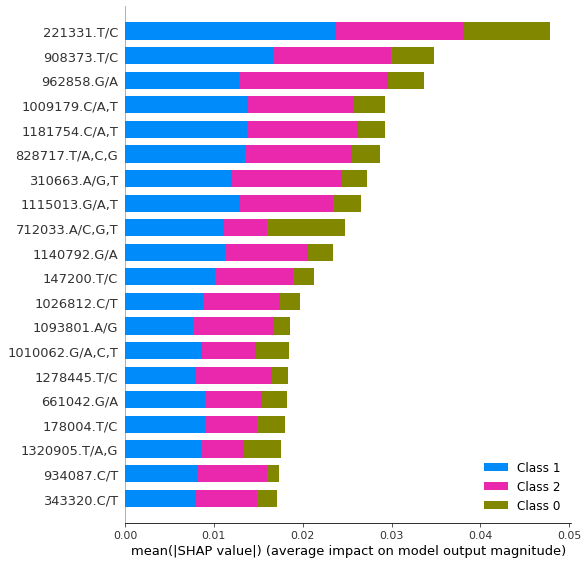

In [323]:
shap.summary_plot(shap_values, dataTN[[top_varaibles[x] for x in selected_features]])

In [446]:
feature_impDF2 = feature_impDF1.copy()
feature_impDF2['Top 10 VIM Features']=feature_impDF2['Features']
del feature_impDF2['Importance']
del feature_impDF2['Features']
del feature_impDF2['Top 10 VIM']

In [447]:
feature_impDF2[0:10]

Top 10 VIM Features
0      712033.A/C,G,T
1          221331.T/C
2        310663.A/G,T
3      828717.T/A,C,G
4          908373.T/C
5       1115013.G/A,T
6       1181754.C/A,T
7          962858.G/A
8     1131910.G/A,C,T
9       1009179.C/A,T

In [438]:
print(feature_impDF1[0:10]['Top 10 VIM Features'])

0     712033.A/C,G,T
1         221331.T/C
2       310663.A/G,T
3     828717.T/A,C,G
4         908373.T/C
5      1115013.G/A,T
6      1181754.C/A,T
7         962858.G/A
8    1131910.G/A,C,T
9      1009179.C/A,T
Name: Top 10 VIM, dtype: object


### For shap clustering 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], dataTN[[top_varaibles[x] for x in selected_features]])


In [337]:
shap_values = explainer.shap_values(ENRtest_featuresT)
shap.force_plot(explainer.expected_value[0], shap_values[0], ENRtest_featuresT)

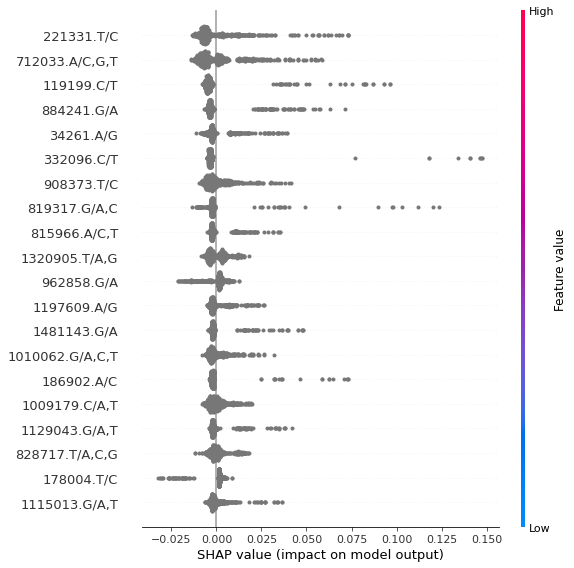

In [265]:
shap.summary_plot(shap_values[0], dataTN[[top_varaibles[x] for x in selected_features]])

## Class Imbalance

In [915]:
y_train = upsampled.Phenotype
X_train = upsampled.drop('Phenotype', axis=1)

undersampled = RandomForestClassifier(n_estimators = 1000,max_depth= 20,random_state = 42).fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

In [917]:
print(classification_report(y_test, undersampled_pred))


                            precision    recall  f1-score   support

            Gastric Cancer       0.46      0.54      0.50        24
    Non Atrophic Gastritis       0.76      0.54      0.63       114
Progressive towards Cancer       0.37      0.63      0.46        41

                  accuracy                           0.56       179
                 macro avg       0.53      0.57      0.53       179
              weighted avg       0.63      0.56      0.57       179



In [931]:
from sklearn import metrics

def compute_roc_auc(index):
    y_predict = ENrfRET.predict_proba(dataTN[[top_varaibles[x] for x in selected_features]].iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(dataTN['Phenotype'].iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

cv = StratifiedKFold(n_splits=2, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(dataTN[[top_varaibles[x] for x in selected_features]], dataTN['Phenotype']), range(2)):
    ENrfRET.fit(dataTN[[top_varaibles[x] for x in selected_features]].iloc[train], dataTN['Phenotype'].iloc[train])
    prediction = ENrfRET.predict(dataTN[[top_varaibles[x] for x in selected_features]].iloc[test])
    print(i+1,"Accuracy:",metrics.accuracy_score(dataTN['Phenotype'].iloc[test], prediction))    
    print(metrics.classification_report(dataTN['Phenotype'].iloc[test], prediction))
    print("----------------------------------------")


1 Accuracy: 0.7366946778711485
                            precision    recall  f1-score   support

            Gastric Cancer       1.00      0.25      0.40        48
    Non Atrophic Gastritis       0.72      0.92      0.81       208
Progressive towards Cancer       0.74      0.59      0.66       101

                  accuracy                           0.74       357
                 macro avg       0.82      0.59      0.62       357
              weighted avg       0.77      0.74      0.71       357

----------------------------------------
2 Accuracy: 0.742296918767507
                            precision    recall  f1-score   support

            Gastric Cancer       0.82      0.29      0.43        48
    Non Atrophic Gastritis       0.72      0.94      0.82       208
Progressive towards Cancer       0.79      0.55      0.65       101

                  accuracy                           0.74       357
                 macro avg       0.78      0.59      0.63       357
         

In [ ]:
for index, row in final_variable_df.iterrows():
    
    if final_variable_df.loc[index, 1]>= read_variant_dict_gtf[3]:
        if final_variable_df.loc[index, 1]<= read_variant_dict_gtf[4]:
            
    final_variable_df.loc[index, "gene" ]= read_variant_dict_gtf[index_i, gene]


In [ ]:
if read_variant_dict_gtf[final_variable_df.loc[1, 1]>= read_variant_dict_gtf[3]][3]:
    if final_variable_df.loc[1, 1]<= read_variant_dict_gtf[4]:
        print (read_variant_dict_gtf[1, "gene_name"])

In [668]:
read_variant_dict_gtf[final_variable_df.loc[1, 1]>= read_variant_dict_gtf[3]][3]

0           13
8          911
16        2515
20        3199
24        4043
         ...  
3622    952453
3630    955244
3634    956260
3646    959872
3650    962720
Name: 3, Length: 451, dtype: int64

# BacGWASim Modeling 

Importing pickel file for modeling 

In [278]:
import pandas as pd
X = pd.read_pickle(r'../bacgwasim/recomb_0.2/results_BacGWASim/simulations/genSim/sims.pickle')

In [279]:
X
#/genSim/sims.pickle')

ID    1:9:C:A  1:10:G:T  1:16:C:T  1:26:A:T  1:31:A:G  1:32:G:C  1:33:C:T  \
zero        0         0         0         0         0         0         0   
1           0         0         0         1         1         0         0   
2           1         0         0         0         0         0         0   
3           0         0         0         0         0         0         0   
4           1         0         1         0         0         0         0   
...       ...       ...       ...       ...       ...       ...       ...   
795         1         0         1         0         0         0         0   
796         1         0         1         0         0         0         0   
797         1         0         1         1         1         1         0   
798         1         0         1         0         0         0         0   
799         0         0         0         0         0         0         0   

ID    1:38:C:G  1:39:C:T  1:51:C:G  ...  1:1673778:G:T  1:1673782:C:T  \
zero         0         0         0  ...              0              0   
1            0         0         0  ...              0              0   
2            0         0         1  ...              0              0   
3            0         0         0  ...              0              0   
4            0         0         1  ...              0              0   
...        ...       ...       ...  ...            ...            ...   
795          0         0         0  ...              0              0   
796          0         0         0  ...              0              0   
797          0         1         1  ...              1              1   
798          0         0         1  ...              1              1   
799          0         0         0  ...              0              0   

ID    1:1673783:C:A  1:1673790:T:A  1:1673791:G:C  1:1673793:C:A  \
zero              0              0              0              0   
1                 1              0              1              1   
2                 0              0              0              0   
3                 0              0              0              1   
4                 1              0              1              1   
...             ...            ...            ...            ...   
795               1              0              1              1   
796               1              0              1              1   
797               1              0              0              1   
798               1              0              0              1   
799               0              0              0              0   

ID    1:1673796:G:A  1:1673799:G:C  1:1673801:A:G  1:1673810:A:C  
zero              0              0              0              0  
1                 0              0              1              1  
2                 0              0              0              1  
3                 0              0              1              1  
4                 0              0              1              0  
...             ...            ...            ...            ...  
795               0              0              1              1  
796               0              0              1              1  
797               0              0              1              0  
798               0              0              1              0  
799               0              0              0              0  

[800 rows x 287147 columns]

In [280]:
#X['ID']=X.index
X = X.reset_index()

In [282]:
del X["index"]

In [283]:
Y=pd.read_csv(r'../bacgwasim/recomb_0.2/results_BacGWASim/simulations/phenSim/0/phenSim.phen',' ',header=None)

In [284]:
Y

0     1  2   3
0    zero  zero  1 NaN
1       1     1  1 NaN
2       2     2  2 NaN
3       3     3  1 NaN
4       4     4  2 NaN
..    ...   ... ..  ..
795   795   795  1 NaN
796   796   796  1 NaN
797   797   797  1 NaN
798   798   798  2 NaN
799   799   799  1 NaN

[800 rows x 4 columns]

In [285]:
mn = pd.DataFrame(Y[2])
#X = pd.concat([X,mn], axis=1)
#X.rename(columns = {2:'Phenotype'}, inplace = True)

Modeling

In [332]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, Y[2], test_size = 0.25, random_state = 42)

In [333]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (600, 287147)
Training Labels Shape: (600,)
Testing Features Shape: (200, 287147)
Testing Labels Shape: (200,)


In [334]:
import numpy as np
train_labels.shape

(600,)

In [335]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data

In [336]:
rf.fit(train_features, train_labels);

In [337]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))
print("Accuracy:",metrics.f1_score(test_labels, predictions,average="macro"))
print("Accuracy:",metrics.recall_score(test_labels, predictions,average="macro"))

Mean Absolute Error: 0.08 degrees.
Accuracy: 0.92
Accuracy: 0.7871774408087258
Accuracy: 0.7485714285714286


In [341]:
print(classification_report(test_labels, predictions))


              precision    recall  f1-score   support

           1       0.93      0.98      0.96       175
           2       0.76      0.52      0.62        25

    accuracy                           0.92       200
   macro avg       0.85      0.75      0.79       200
weighted avg       0.91      0.92      0.91       200



In [299]:
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_,index=X.iloc[:,:].columns).sort_values(ascending=False)

In [304]:
feature_impDF = pd.DataFrame({'Features':feature_imp.index, 'Importance':feature_imp.values})
#top_varaibles = list(feature_impDF['Features'][feature_impDF["Importance"]>0.0001])

In [305]:
feature_impDF

Features  Importance
0       1:1368272:G:C    0.000914
1        1:820687:G:C    0.000721
2       1:1640625:C:T    0.000620
3         1:35874:C:G    0.000585
4        1:820684:A:T    0.000566
...               ...         ...
287142   1:586477:C:A    0.000000
287143   1:586491:T:A    0.000000
287144   1:586512:G:A    0.000000
287145   1:586521:T:G    0.000000
287146  1:1673810:A:C    0.000000

[287147 rows x 2 columns]

/home/vbha0006/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'VIM'),
 Text(0, 0.5, 'Number of Variables'),
 Text(0.5, 1.0, 'Distribution of Variables ')]

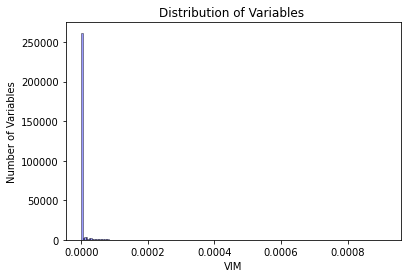

In [321]:
##### import matplotlib.pyplot as plt
import seaborn as sns


# seaborn histogram

sns.distplot(feature_impDF["Importance"], hist=True, kde=False, 
             bins=200, color = 'blue',
             hist_kws={'edgecolor':'black'}).set(xlabel="VIM",ylabel='Number of Variables',title='Distribution of Variables ')

/home/vbha0006/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'VIM'),
 Text(0, 0.5, 'Number of Variables'),
 Text(0.5, 1.0, 'Distribution of Variables ')]

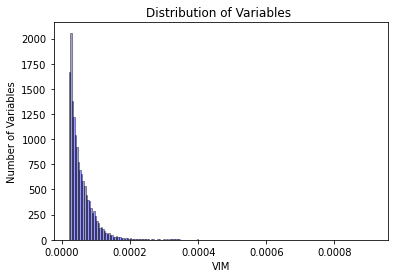

In [328]:
##### import matplotlib.pyplot as plt
import seaborn as sns


# seaborn histogram

sns.distplot(list(feature_impDF["Importance"][feature_impDF["Importance"]>0.00002])
, hist=True, kde=False, 
             bins=200, color = 'blue',
             hist_kws={'edgecolor':'black'}).set(xlabel="VIM",ylabel='Number of Variables',title='Distribution of Variables ')

In [319]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 42)
info_dfk=pd.DataFrame()
for i in range(1,900,+10):
    vim_temp = 0.0000001*i
    top_varaiblesTesting = list(feature_impDF['Features'][feature_impDF["Importance"]>=vim_temp])
    
    #ENXnRe = np.array(dataTN[top_varaiblesTesting])


# Split the data into training and testing sets
    ENRtrain_features, ENRtest_features, ENRtrain_labels, 
    ENRtest_labels = train_test_split(X[top_varaiblesTesting], Y[2], test_size = 0.25, random_state = 42)

    rf.fit(ENRtrain_features,ENRtrain_labels)

    ENRprediction=rf.predict(ENRtest_features)
    ENRprediction1=rf.predict(ENRtrain_features)

    mn= pd.DataFrame(columns = ['vim above or equal','accuracy'])
    mn.loc[0,'vim above or equal']=vim_temp
    mn.loc[0,'Test Accuracy']= metrics.accuracy_score(ENRtest_labels, ENRprediction)
    mn.loc[0,'Train Accuracy']= metrics.accuracy_score(ENRtrain_labels, ENRprediction1)

    mn.loc[0,'Number of Variables selected'] = len(top_varaiblesTesting)
    print(mn)
    info_dfk = pd.concat([info_dfk,mn],axis=0)
    


  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0                0.0      NaN           0.92             1.0   

   Number of Variables selected  
0                       26898.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0           0.000001      NaN           0.92             1.0   

   Number of Variables selected  
0                       26709.0  
  vim above or equal accuracy  Test Accuracy  Train Accuracy  \
0           0.000002      NaN           0.92             1.0   

   Number of Variables selected  
0                       26277.0  


KeyboardInterrupt: 

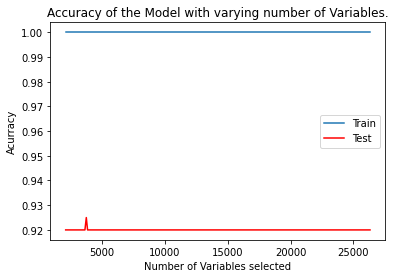

In [314]:
import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(data=info_dfk, y="Train Accuracy", x="Number of Variables selected", label='Train',
               ).set(title='Accuracy of the Model with VIM above or equal to a specific value')
sns.lineplot(data=info_dfk, y="Test Accuracy", x="Number of Variables selected",label='Test', 
             color='r' ).set(title='Accuracy of the Model with varying number of Variables.',ylabel='Acurracy')
plt.show()

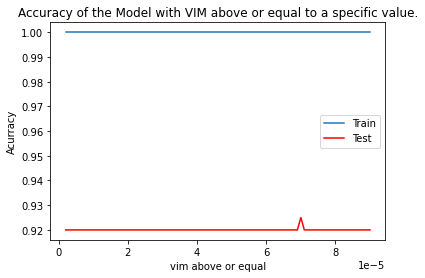

In [318]:
fig, ax = plt.subplots()
sns.lineplot(data=info_dfk, y="Train Accuracy", x="vim above or equal", label='Train',
               ).set(title='Accuracy of the Model with VIM above or equal to a specific value')
sns.lineplot(data=info_dfk, y="Test Accuracy", x="vim above or equal",label='Test', 
             color='r' ).set(title='Accuracy of the Model with VIM above or equal to a specific value.',ylabel='Acurracy')

plt.show()

In [376]:
feature_impDF["Importance"]

0         0.000914
1         0.000721
2         0.000620
3         0.000585
4         0.000566
            ...   
287142    0.000000
287143    0.000000
287144    0.000000
287145    0.000000
287146    0.000000
Name: Importance, Length: 287147, dtype: float64

In [356]:
top_varaibles = list(feature_impDF['Features'][feature_impDF["Importance"]>0.00009])
len(top_varaibles)

2132

In [357]:
#max_features="auto",criterion='entropy',max_depth=20,n_estimators=1000,random_state = 42
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
import numpy as np

ENXnRet = np.array(X[top_varaiblesTesting])


# Split the data into training and testing sets
ENRtrain_featuresT, ENRtest_featuresT, ENRtrain_labelsT, ENRtest_labelsT = train_test_split(X[top_varaibles], 
                                                                                            Y[2], 
                                                                                            test_size = 0.25, 
                                                                                            random_state = 42)

from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000,random_state = 42)
                             #, min_samples_split=5,max_terminal_nodes=10, min_samples_leaf=200,random_state = 42)
# Train the model on training data

rf.fit(ENRtrain_featuresT,ENRtrain_labelsT)

ENRpredictionT=rf.predict(ENRtest_featuresT)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ENRtest_labelsT, ENRpredictionT))
print("Accuracy:",metrics.f1_score(ENRtest_labelsT, ENRpredictionT,average="macro"))
print("Accuracy:",metrics.recall_score(ENRtest_labelsT, ENRpredictionT,average="macro"))

Accuracy: 0.92
Accuracy: 0.7871774408087258
Accuracy: 0.7485714285714286


## Boruta to BACGWASIM

In [359]:
feat_mine = BorutaPy(rf, n_estimators ='auto', verbose=2, random_state=1,max_iter = 50)


feat_mine.fit(ENRtrain_featuresT.values,ENRtrain_labelsT.values.ravel())


Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	2132
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	0
Tentative: 	756
Rejected: 	1376
Iteration: 	9 / 50
Confirmed: 	50
Tentative: 	706
Rejected: 	1376
Iteration: 	10 / 50
Confirmed: 	50
Tentative: 	706
Rejected: 	1376
Iteration: 	11 / 50
Confirmed: 	50
Tentative: 	706
Rejected: 	1376
Iteration: 	12 / 50
Confirmed: 	64
Tentative: 	484
Rejected: 	1584
Iteration: 	13 / 50
Confirmed: 	64
Tentative: 	484
Rejected: 	1584
Iteration: 	14 / 50
Confirmed: 	64
Tentative: 	484
Rejected: 	1584
Iteration: 	15 / 50
Confirmed: 	64
Tentative: 	484
Rejected: 	1584
Iteration: 	16 / 50
Confir

TypeError: '(slice(None, None, None), array([ True,  True,  True, ..., False, False, False]))' is an invalid key

In [362]:
feature_ranks101 = list(zip(top_varaibles, 
                         feat_mine.ranking_, 
                         feat_mine.support_))

# iterate through and print out the results
for feat in feature_ranks101:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: 1:1368272:G:C             Rank: 1,  Keep: True
Feature: 1:820687:G:C              Rank: 1,  Keep: True
Feature: 1:1640625:C:T             Rank: 1,  Keep: True
Feature: 1:35874:C:G               Rank: 1,  Keep: True
Feature: 1:820684:A:T              Rank: 1,  Keep: True
Feature: 1:826572:G:C              Rank: 14,  Keep: False
Feature: 1:1442606:A:T             Rank: 1,  Keep: True
Feature: 1:114607:C:T              Rank: 1,  Keep: True
Feature: 1:1381938:G:T             Rank: 1,  Keep: True
Feature: 1:663811:A:T              Rank: 1,  Keep: True
Feature: 1:1440950:T:A             Rank: 1,  Keep: True
Feature: 1:663819:C:A              Rank: 1,  Keep: True
Feature: 1:35882:C:G               Rank: 1,  Keep: True
Feature: 1:1614526:T:C             Rank: 1,  Keep: True
Feature: 1:1429732:G:A             Rank: 1,  Keep: True
Feature: 1:35842:T:C               Rank: 1,  Keep: True
Feature: 1:162083:T:C              Rank: 1,  Keep: True
Feature: 1:271616:A:G              Rank: 1,  K

# VIM for bacGWASim

In [365]:
for i in feature_ranks:
    if i[0]=="1:2138:C:A":
        print(i)

Doesn't match with the two VIM list.

In [ ]:
1:2138:C:A	A	0.2925	2.30259
1:6076:T:A	A	0.18125	2.70805
1:147303:G:T	T	0.38375	1.94591
1:153874:G:A	A	0.18625	2.30259
1:204902:C:G	G	0.16875	1.09861
1:221430:A:G	G	0.11375	2.3979
1:272237:G:T	T	0.13875	0.693147
1:448267:A:G	G	0.35375	1.38629
1:456736:G:C	C	0.2325	2.99573
1:576589:A:C	C	0.18	1.38629
1:663819:C:A	A	0.1675	2.70805
1:701020:T:C	C	0.15375	0.693147
1:790484:A:T	T	0.3825	2.99573
1:952541:C:G	G	0.3525	2.3979
1:1150474:A:G	G	0.205	1.94591
1:1533881:T:C	C	0.35375	1.09861

In [367]:
feature_impDF['Features'][feature_impDF["Features"]=="1:2138:C:A"]

196461    1:2138:C:A
Name: Features, dtype: object

In [370]:
feature_impDF[feature_impDF["Features"]=="1:147303:G:T"]

Features  Importance
218714  1:147303:G:T         0.0

In [372]:
feature_impDF[feature_impDF["Features"]=="1:6076:T:A"]

Features  Importance
15598  1:6076:T:A    0.000019

In [375]:
feature_impDF[feature_impDF["Features"]=="1:1533881:T:C"]

Features  Importance
83864  1:1533881:T:C         0.0